# TRAFFIC AT SUUR-S.-LÕÕTSA. BASIC MODEL (lag=27) and 
# ML MODELLING: LinearRegression, LinearRegression with Huber Loss, XGBoost


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import pandas as pd
import os
import numpy as np
import category_encoders as ce
import shap
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
from xgboost import plot_importance
from collections import Counter
from statsmodels.regression.linear_model import OLS
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from pandas import read_csv
from pandas import Grouper
from matplotlib import pyplot
from datetime import datetime
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
#import func_clustering_centroids as cs
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import HuberRegressor
from numpy import asarray
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

In [3]:
import matplotlib.pyplot as mpl
import matplotlib.cm as mcm
import pandas as pd
import numpy as np
from typing import List, Tuple

In [4]:
def pdread_csv(file_path):
    data = pd.read_csv(file_path, sep=',')
    return data

# Loading traffic data

In [5]:
#path = "/home/meik/Mainor_ylemiste/analysis_traffic/data/year_30m_CVSBM/SSL/"

path = "/home/meik/Mainor_ylemiste/data_traffic/crosses_all/data_MTKNF/year_30m_CVSBM/SSL/"

os.chdir(path)
path

'/home/meik/Mainor_ylemiste/data_traffic/crosses_all/data_MTKNF/year_30m_CVSBM/SSL/'

In [6]:
data = []
for file in os.listdir():
    if file.endswith(".csv"):
        file_path = f"{path}{file}"
        dd = pdread_csv(file_path)   
        data.append(dd)
        
data = (pd.concat(data, ignore_index=True, sort=False)).fillna(0)
print(data.shape)

(4779, 11)


In [7]:
data = data.sort_values(by='timestamp')
data.reset_index(inplace=True)
data.head(5)
del data['index']

In [8]:
# convert column "timestamp" into Datetime objects, add into original column "timestamp"
convertToDate = lambda row: datetime.strptime(row['timestamp'], "%Y-%m-%d %H:%M:%S")
data['timestamp'] = data.apply(convertToDate, axis=1)
#data

In [9]:
days_TS = data['timestamp'].dt.strftime('%Y-%m-%d')

In [10]:
data.set_index('timestamp', inplace=True)
data.head(2)

,bicycle_linnak_sisse,bicycle_linnak_valja,car_linnak_sisse,car_linnak_valja,escooter_linnak_valja,motorbike_linnak_sisse,motorbike_linnak_valja,van_linnak_sisse,van_linnak_valja,escooter_linnak_sisse
timestamp,,,,,,,,,,
2021-03-02 06:00:00,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-02 06:30:00,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### DISTINGUISH BETWEEN HEAVY AND LIGHT TRAFFIC

In [11]:
print(data.columns)

Index(['bicycle_linnak_sisse', 'bicycle_linnak_valja', 'car_linnak_sisse',
       'car_linnak_valja', 'escooter_linnak_valja', 'motorbike_linnak_sisse',
       'motorbike_linnak_valja', 'van_linnak_sisse', 'van_linnak_valja',
       'escooter_linnak_sisse'],
      dtype='object')


In [12]:
df_heavy = data[['car_linnak_sisse','car_linnak_valja', 'van_linnak_sisse', 'van_linnak_valja',]]

In [13]:
df_light = data[['bicycle_linnak_sisse', 'bicycle_linnak_valja', 'escooter_linnak_valja', 'motorbike_linnak_sisse',
       'motorbike_linnak_valja', 'escooter_linnak_sisse']]
df_light = df_light.copy()

In [14]:
incom_outgo = ['bicycle_linnak_sisse', 'bicycle_linnak_valja', 'escooter_linnak_valja', 'motorbike_linnak_sisse',
       'motorbike_linnak_valja', 'escooter_linnak_sisse']
df_light['light_sisse_valja'] = df_light[incom_outgo].sum(axis=1)

## Extracting valuable TRAFFIC data based on ML model performance

* Car_linnak_sisse, Car_linnak_valja: 06.04.2021-12.08.2021 and 07.09.2021-18.04.2022
* Van_linnak_sisse, Van_linnak_valja: 06.04.2021-12.08.2021 and 07.09.2021-18.04.2022
* Light_sisse_valja: 06.04.2021-24.02.2022 and 22.03.2022-18.04.2022


In [15]:
data.reset_index(inplace=True)

### CAR/VAN Data  with excluded time_period from 12.08.2021-07.09.2021

In [16]:
start_all = '2021-04-06 06:00:00'

mask_all= (data['timestamp'] >= start_all) 
data = data.loc[mask_all]

In [17]:
df_carvan = data.copy()
df_light_inout = data.copy()

In [18]:
start_date = '2021-08-12 19:00:00'
end_date = '2021-09-07 06:00:00'

mask1 = (df_carvan['timestamp'] <= start_date) 
mask2 = (df_carvan['timestamp'] >= end_date) 

before_Aug = df_carvan.loc[mask1]
after_Sept = df_carvan.loc[mask2]

df_carvan = pd.concat([before_Aug, after_Sept], axis=0)

In [19]:
start_light = '2022-02-24 19:00:00'
end_light = '2022-03-22 06:00:00'

mask3 = (df_light_inout['timestamp'] <= start_light) 
mask4 = (df_light_inout['timestamp'] >= end_light) 

before_Feb = df_light_inout.loc[mask3]
after_March = df_light_inout.loc[mask4]

df_light_inout = pd.concat([before_Feb, after_March], axis=0)

In [20]:
df_carvan.set_index('timestamp', inplace=True)
df_light_inout.set_index('timestamp', inplace=True)

In [21]:
df_carvan_in = df_carvan.copy()
df_carvan_out = df_carvan.copy()
df_light = df_light_inout.copy()

In [22]:
df_carvan_in = df_carvan_in[['car_linnak_sisse', 'van_linnak_sisse']]

df_carvan_out = df_carvan_out[['car_linnak_valja' ,'van_linnak_valja']]

df_light = df_light[['bicycle_linnak_sisse', 'bicycle_linnak_valja', 'escooter_linnak_valja', 
                     'motorbike_linnak_sisse', 'motorbike_linnak_valja']]

In [23]:
incom_outgo = ['bicycle_linnak_sisse', 'bicycle_linnak_valja', 'escooter_linnak_valja', 
                     'motorbike_linnak_sisse', 'motorbike_linnak_valja']
df_light['light_sisse_valja'] = df_light[incom_outgo].sum(axis=1).astype('int64')

In [24]:
print(df_carvan_in.shape)
print(df_carvan_out.shape)
print(df_light.shape)

(4131, 2)
(4131, 2)
(4131, 6)


# Loading EMHI data;
# Extracting time_periods corrsponding to valuable Traffic data

    * Car_linnak_sisse, Car_linnak_valja: 06.04.2021-12.08.2021 and 07.09.2021-18.04.2022
    * Van_linnak_sisse, Van_linnak_valja: 06.04.2021-12.08.2021 and 07.09.2021-18.04.2022
    * Light_sisse_valja: 06.04.2021-24.02.2022 and 22.03.2022-18.04.2022


In [25]:
path = "/home/meik/Mainor_ylemiste/data_emhi/Ilmaandmed 01.03-31.12.2021a/data_TKN/from04.2021/"

os.chdir(path)
path

'/home/meik/Mainor_ylemiste/data_emhi/Ilmaandmed 01.03-31.12.2021a/data_TKN/from04.2021/'

In [26]:
data_emhi = []
for file in os.listdir():
    if file.endswith(".csv"):
        file_path = f"{path}{file}"
        dd = pdread_csv(file_path)   
        data_emhi.append(dd)
        
data_emhi = (pd.concat(data_emhi, ignore_index=True, sort=False)).fillna(0)
print(data_emhi.shape)

(4401, 10)


In [27]:
data_emhi = data_emhi.sort_values(by='kuupaev')
data_emhi.reset_index(inplace=True)
data_emhi.head(5)
del data_emhi['index']

In [28]:
# convert column "timestamp" into Datetime objects, add into original column "timestamp"
convertToDate = lambda row: datetime.strptime(row['kuupaev'], "%Y-%m-%d %H:%M:%S")
data_emhi['kuupaev'] = data_emhi.apply(convertToDate, axis=1)
#data

In [29]:
#print(data_emhi.loc[data_emhi['RH'] > 100])# index of a value in df

### Extracting EMHI data corresponding to valuable Traffic data

In [30]:
start_all = '2021-04-06 05:50:00'

start_date = '2021-08-12 18:50:00'
end_date = '2021-09-07 05:50:00'

start_light = '2022-02-24 18:50:00'
end_light = '2022-03-22 05:50:00'

In [31]:
mask_all_emhi= (data_emhi['kuupaev'] >= start_all) 
data_emhi = data_emhi.loc[mask_all_emhi]

In [32]:
data_emhi_light = data_emhi.copy()

### DATA_EMHI FOR CAR and VAN

In [33]:
mask1_emhi = (data_emhi['kuupaev'] <= start_date) 
mask2_emhi = (data_emhi['kuupaev'] >= end_date) 
before_Aug_emhi = data_emhi.loc[mask1_emhi]
after_Sept_emhi = data_emhi.loc[mask2_emhi]

data_emhi = pd.concat([before_Aug_emhi, after_Sept_emhi], axis=0)

In [34]:
data_emhi.set_index('kuupaev', inplace=True)

### Classification of "weather_phenomena (ilmastiku nähtus)".

Weather phenomena is distinguished between **4 main classes**, which are related to weather phenomena abbreviations. 

In [35]:
weather_phCAT = []

for i in data_emhi['ilmast_nahtused']:
    if i == 0:
        weather_phCAT.append("NA")
    elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ' or i == "RA" or i == "RA " or i=='VCTS' or i == "RA*" or i == "RA* " or i == "SHRA" or i == "SHRA " or i == "SHRA* VCTS" or i == "SHRA*VCTS" or i=='TSRA**' or i =='TSRA' or i=='SHRA*' or i=='SHRA**':
        weather_phCAT.append("RA")
    elif i == "DZ" or i == "DZ " or i == "DZ*" or i == "DZ* " or i == "FZDZ*" or i == "FZDZ* " or i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        weather_phCAT.append("DZ") 
        #weather_phCAT.append("RA")
    elif i == "SN" or i=='SHGS*' or i=='SHSN** SHGS'  or i=='SHSN**' or i == "SN " or i == "SN*" or i == "SN* " or i == "SN*  " or i == "SN**" or i == "SN** " or i == "SHSN" or i == "SHSN " or i == "SHSN*" or i == "SHSN* ":
        weather_phCAT.append("SN")
    #elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ':
        #weather_phCAT.append("RASN")
    #elif i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        #weather_phCAT.append("RADZ")
    else:
        weather_phCAT.append(i)

In [36]:
weather_phNUM = []

for i in data_emhi['ilmast_nahtused']:
    if i == 0:
        weather_phNUM.append(1)
    elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ' or i == "RA" or i == "RA " or i=='VCTS' or i == "RA*" or i == "RA* " or i == "SHRA" or i == "SHRA " or i == "SHRA* VCTS" or i == "SHRA*VCTS" or i=='TSRA**' or i =='TSRA' or i=='SHRA*' or i=='SHRA**':
        weather_phNUM.append(2)
    elif i == "DZ" or i == "DZ " or i == "DZ*" or i == "DZ* " or i == "FZDZ*" or i == "FZDZ* " or i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        weather_phNUM.append(3) 
        #weather_phNUM.append(2)
    elif i == "SN" or i=='SHGS*' or i=='SHSN** SHGS'  or i=='SHSN**' or i == "SN " or i == "SN*" or i == "SN* " or i == "SN*  " or i == "SN**" or i == "SN** " or i == "SHSN" or i == "SHSN " or i == "SHSN*" or i == "SHSN* ":
        weather_phNUM.append(3)             
    #elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ':
        #weather_phCAT.append("RASN")
    #elif i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        #weather_phCAT.append("RADZ")
    else:
        weather_phNUM.append(i)

In [37]:
print(len(weather_phCAT))
combin_counts = Counter(weather_phCAT)
print(len(combin_counts.keys()))
print(combin_counts.keys())
print(combin_counts.values())

4131
4
dict_keys(['NA', 'SN', 'RA', 'DZ'])
dict_values([3318, 347, 286, 180])


In [38]:
data_emhi.insert(loc=5, column='weather_phenCAT', value=weather_phCAT)

In [39]:
data_emhi.insert(loc=6, column='weather_phenLAB', value=weather_phNUM)

In [40]:
visibility0 = []
for i in data_emhi['nahtavus']:
    if i == 10 or i == "10":
        visibility0.append(int(i)*1000)
    else:
        visibility0.append(i)     

In [41]:
visibility = []
for i in visibility0:     
    if type(i) == str and (len(i) == 4 or len(i) == 3):
        visibility.append(int(i))
    elif type(i) == str and len(i) > 5:
        ch = '/'
        visibility.append(int(i.split(ch, 1)[0]))
    else:
        visibility.append(i)

In [42]:
data_emhi.insert(loc=4, column='visibility_m', value=visibility)

In [43]:
#plt.rcParams["figure.figsize"] = (12,8);
#data_emhi.hist()

## Encoding the weather data using Binary encoding

In [44]:
encoderBi = ce.BinaryEncoder(cols =['weather_phenCAT'])
newdataBi = encoderBi.fit_transform(data_emhi['weather_phenCAT'])

data_emhi = pd.concat([data_emhi, newdataBi], axis = 1)
#data_emhi = data_emhi.drop(['weather_phenCAT'], axis = 1)

In [45]:
#data_emhi[630:650]

In [46]:
# Dummy encoding of weather phenomena
#data_emhi = pd.get_dummies(data_emhi, prefix=['weather_ph'], columns=['weather_phenCAT'])

### DATA_EMHI FOR LIGHT_SISSE/VÄLJA

In [47]:
mask3_emhi = (data_emhi_light['kuupaev'] <= start_light) 
mask4_emhi = (data_emhi_light['kuupaev'] >= end_light) 
before_Feb_emhi = data_emhi_light.loc[mask3_emhi]
after_Mar_emhi = data_emhi_light.loc[mask4_emhi]

data_emhi_light = pd.concat([before_Feb_emhi, after_Mar_emhi], axis=0)

In [48]:
data_emhi_light.set_index('kuupaev', inplace=True)

### Classification of "weather_phenomena (ilmastiku nähtus)".

Weather phenomena is distinguished between **4 main classes**, which are related to weather phenomena abbreviations. 

In [49]:
weather_phCAT = []

for i in data_emhi_light['ilmast_nahtused']:
    if i == 0:
        weather_phCAT.append("NP")
    elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ' or i == "RA" or i == "RA " or i=='VCTS' or i == "RA*" or i == "RA* " or i == "SHRA" or i == "SHRA " or i == "SHRA* VCTS" or i == "SHRA*VCTS" or i=='TSRA**' or i =='TSRA' or i=='SHRA*' or i=='SHRA**':
        weather_phCAT.append("RA")
    elif i == "DZ" or i == "DZ " or i == "DZ*" or i == "DZ* " or i == "FZDZ*" or i == "FZDZ* " or i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        weather_phCAT.append("DZ")  
    elif i == "SN" or i=='SHGS*' or i=='SHSN** SHGS'  or i=='SHSN**' or i == "SN " or i == "SN*" or i == "SN* " or i == "SN*  " or i == "SN**" or i == "SN** " or i == "SHSN" or i == "SHSN " or i == "SHSN*" or i == "SHSN* ":
        weather_phCAT.append("SN")                
    #elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ':
        #weather_phCAT.append("RASN")
    #elif i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        #weather_phCAT.append("RADZ")
    else:
        weather_phCAT.append(i)

In [50]:
weather_phNUM = []

for i in data_emhi_light['ilmast_nahtused']:
    if i == 0:
        weather_phNUM.append(1)
    elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ' or i == "RA" or i == "RA " or i=='VCTS' or i == "RA*" or i == "RA* " or i == "SHRA" or i == "SHRA " or i == "SHRA* VCTS" or i == "SHRA*VCTS" or i=='TSRA**' or i =='TSRA' or i=='SHRA*' or i=='SHRA**':
        weather_phNUM.append(2)
    elif i == "DZ" or i == "DZ " or i == "DZ*" or i == "DZ* " or i == "FZDZ*" or i == "FZDZ* " or i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        weather_phNUM.append(3) 
    elif i == "SN" or i=='SHGS*' or i=='SHSN** SHGS'  or i=='SHSN**' or i == "SN " or i == "SN*" or i == "SN* " or i == "SN*  " or i == "SN**" or i == "SN** " or i == "SHSN" or i == "SHSN " or i == "SHSN*" or i == "SHSN* ":
        weather_phNUM.append(4)             
    #elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ':
        #weather_phCAT.append("RASN")
    #elif i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        #weather_phCAT.append("RADZ")
    else:
        weather_phNUM.append(i)

In [51]:
print(len(weather_phCAT))
combin_counts = Counter(weather_phCAT)
print(len(combin_counts.keys()))
print(combin_counts.keys())
print(combin_counts.values())

4131
4
dict_keys(['NP', 'SN', 'RA', 'DZ'])
dict_values([3279, 325, 348, 179])


In [52]:
data_emhi_light.insert(loc=5, column='weather_phenCAT', value=weather_phCAT)

In [53]:
data_emhi_light.insert(loc=6, column='weather_phenLAB', value=weather_phNUM)

In [54]:
visibility0 = []
for i in data_emhi_light['nahtavus']:
    if i == 10 or i == "10":
        visibility0.append(int(i)*1000)
    else:
        visibility0.append(i)     

In [55]:
visibility = []
for i in visibility0:     
    if type(i) == str and (len(i) == 4 or len(i) == 3):
        visibility.append(int(i))
    elif type(i) == str and len(i) > 5:
        ch = '/'
        visibility.append(int(i.split(ch, 1)[0]))
    else:
        visibility.append(i)

In [56]:
data_emhi_light.insert(loc=4, column='visibility_m', value=visibility)

In [57]:
#plt.rcParams["figure.figsize"] = (12,8);
#data_emhi_light.hist()

## Encoding the weather data_light using Binary encoding

In [58]:
#data_emhi_light_bi = data_emhi_light.copy()
#encoderBi_l = ce.BinaryEncoder(cols =['weather_phenCAT'])
#newdataBi_l = encoderBi_l.fit_transform(data_emhi_light_bi)
#newdataBi_l.head(5)

In [59]:
encoderBi_l = ce.BinaryEncoder(cols =['weather_phenCAT'])
newdataBi_l = encoderBi_l.fit_transform(data_emhi_light['weather_phenCAT'])

data_emhi_light = pd.concat([data_emhi_light, newdataBi_l], axis = 1)
#data_emhi = data_emhi.drop(['weather_phenCAT'], axis = 1)


In [60]:
data_emhi_light.head(3)

,kellaaeg_utc,tuulesuund,tuulekiirus,nahtavus,visibility_m,ilmast_nahtused,weather_phenCAT,weather_phenLAB,pilvede_alapiir,temperatuur,RH,sademete_hulk,weather_phenCAT_0,weather_phenCAT_1,weather_phenCAT_2
kuupaev,,,,,,,,,,,,,,,
2021-04-06 05:50:00,02:50:00,190,11,10,10000,0,NP,1,1./1400,-1.8,88,0.0,0,0,1
2021-04-06 06:20:00,03:20:00,190,12,10,10000,0,NP,1,2./1300,-1.5,87,0.0,0,0,1
2021-04-06 06:50:00,03:50:00,190,13,10,10000,0,NP,1,7200,-1.1,86,0.0,0,0,1


# Lagged TRAFFIC data (previous observation (lag))

There are lags as follows:

* Lag = 27 (one day lag);
* Lag = 54 (two days lag);
* Lag = 81 (one week lag).

In [61]:
car_sslin_lag27 = df_carvan_in['car_linnak_sisse'].shift(-27)
car_sslin_lag54 = df_carvan_in['car_linnak_sisse'].shift(-54)
car_sslin_lag81 = df_carvan_in['car_linnak_sisse'].shift(-81)

In [62]:
car_sslout_lag27 = df_carvan_out['car_linnak_valja'].shift(-27)
car_sslout_lag54 = df_carvan_out['car_linnak_valja'].shift(-54)
car_sslout_lag81 = df_carvan_out['car_linnak_valja'].shift(-81)

In [63]:
van_sslin_lag27 = df_carvan_in['van_linnak_sisse'].shift(-27)
van_sslin_lag54 = df_carvan_in['van_linnak_sisse'].shift(-54)
van_sslin_lag81 = df_carvan_in['van_linnak_sisse'].shift(-81)

In [64]:
van_sslout_lag27 = df_carvan_out['van_linnak_valja'].shift(-27)
van_sslout_lag54 = df_carvan_out['van_linnak_valja'].shift(-54)
van_sslout_lag81 = df_carvan_out['van_linnak_valja'].shift(-81)

In [65]:
light_ssl_lag27 = df_light['light_sisse_valja'].shift(-27)
light_ssl_lag54 = df_light['light_sisse_valja'].shift(-54)
light_ssl_lag81 = df_light['light_sisse_valja'].shift(-81)

# DATA TRANSFORMATION METHODS

### * Logged Transformation: take a log of each individual value of time-series data

 Reduces the variance of time-series data.
 
 ### NB! Log transform produces infinity !

In [66]:
def log_transform(data, field_name):
    
    data_log = data[field_name].apply(lambda x : np.log(x))
    
    return data_log

## * Power Transformations

Reduces the variance of time-series data.

In [67]:
def power_transform(data, field_name):
    
    data_powsq = data[field_name].apply(lambda x : x ** 0.5)
    data_powcu = data[field_name].apply(lambda x : x ** 0.3333333333333333)

    return data_powsq, data_powcu

## * Moving Window Functions

Calculate rolling mean over a selected period and subtract it from original time-series to get de-trended time-series.

In [68]:
def rolling_mean(data, field_name, window=1):
    rolling_mean = data[field_name].rolling(window = window).mean()
    data_detrended = data[field_name] - rolling_mean
    
    return data_detrended

## * Moving Window Function on Power Transformed Time-Series

It is possible to apply more than one transformation.
* First apply power transformation to time-series
* Then take a rolling mean over a selected period
* Then subtract rolled time-series from power-transformed time-series to get final time-series.


In [69]:
def power_rolmean(data, field_name, window=1):
    
    power = pd.DataFrame(data[field_name].apply(lambda x : np.log(x)))
    rol_mean = power.rolling(window = window).mean()
    final = power - rol_mean

    return final

## * Linear Regression to Remove Trend

Linear regression model can be applied to remove the trend. 

* Fit a linear regression model to time-series data
* Use a fit model to predict time-series values from beginning to end
* Subtract predicted values from original time-series to remove the trend.

In [70]:
def linr_detrend(data, field_name):
       
    least_squares = OLS(data[field_name].values, list(range(data.shape[0])))
    result = least_squares.fit()

    fit = pd.Series(result.predict(list(range(data.shape[0]))), index = data.index)
    data_ols_detrended = data[field_name] - fit
    
    return data_ols_detrended

# Removing Seasonality
Remove seasonality by differencing technique: use differencing over various de-trended time-series calculated above.

## * Differencing Over Power Transformed Time-Series

Differencing is applied to power transformed time-series by shifting its value by 1 period and subtracting it from original power transformed time-series.

It is common to try shifting time-series by different time-periods to remove seasonality and get stationary time-series.

In [71]:
def power_transform_shift(data, field_name, periods=1):
    
    data_pow = data[field_name].apply(lambda x : x ** 0.5)
    data_pow_shift = data_pow - data_pow.shift(periods=periods)
    return data_pow_shift

In [72]:
def transform_All_hist(data, field_name, window=None):
    
    #log = log_transform(data, field_name)
    powsq, powcu= power_transform(data, field_name)
    rolwin = rolling_mean(data, field_name, window=27)
    powrolw =  power_rolmean(data, field_name, window=27)
    linr = linr_detrend(data, field_name)
    pow_shift = power_transform_shift(data, field_name, periods=1)
    
    
    plt.rcParams["figure.figsize"] = (15,15)
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
    
    avg_d1= round(powsq.mean(),1)
    std_d1= round(powsq.std(),1)
    
    avg_d2 = round(powcu.mean(),1)
    std_d2 = round(powcu.std(),1)
    
    avg_d3 = round(rolwin.mean(),1)
    std_d3 = round(rolwin.std(),1)
  
    avg_d4 = round(powrolw.mean(),1)
    std_d4 = round(powrolw.std(),1)
       
    avg_d5 = round(linr.mean(),1)
    std_d5 = round(linr.std(),1)
  
    avg_d6 = round(pow_shift.mean(),1)
    std_d6 = round(pow_shift.std(),1) 
    
    
    ax1.set_xlabel(f"Square root: mean {avg_d1}, std {std_d1}", size=14)
    powsq.dropna().hist(legend=True,ax=ax1)

    ax2.set_xlabel(f"Cube root: mean {avg_d2}, std {std_d2}", size=14)
    powcu.dropna().hist(legend=True, ax=ax2)

    ax3.set_xlabel(f"Rolling window: mean {avg_d3}, std {std_d3}", size=14)
    rolwin.dropna().hist(legend=True,ax=ax3)

    ax4.set_xlabel(f"Rolling wind.on log transf.: mean {avg_d4}, std {std_d4}", size=14)
    powrolw.dropna().hist(legend=True, ax=ax4)
    
    ax5.set_xlabel(f"LinearRegression: mean {avg_d5}, std {std_d5}", size=14)
    linr.dropna().hist(legend=True,ax=ax5)

    ax6.set_xlabel(f"Differencing Over Sq.root transf.: mean {avg_d6}, std {std_d6}", size=14)
    pow_shift.dropna().hist(legend=True, ax=ax6)
    
    pyplot.show()

## TRANSFORMATION OF TRAFFIC DATA

### NB! At the moment no transformation of TRAFFIC DATA

## TRANSFORMATION OF WEATHER DATA

In [73]:
print("ORIGINAL WEATHER FOR CAR/VAN LINNAK_SISSE/VÄLJA", data_emhi.shape)
print("ORIGINAL WEATHER FOR LIGHT_TRAFFIC", data_emhi_light.shape)

ORIGINAL WEATHER FOR CAR/VAN LINNAK_SISSE/VÄLJA (4131, 15)
ORIGINAL WEATHER FOR LIGHT_TRAFFIC (4131, 15)


## -- FOR CAR/VAN SISSE/VÄLJA

### * Wind_Speed [km/h]

Convert wind_speed from knots to km/h.

Teisendamine käib järgmise valemi järgi 1 sõlm = 1,852 km/h = 0,51444 m/s.


In [74]:
wind_speedkm = []

for i in data_emhi['tuulekiirus']:
    km_h = i * 1.852 
    wind_speedkm.append(km_h)

In [75]:
data_emhi.insert(loc=3, column='wind_speedkm', value=wind_speedkm)

In [76]:
wind_speed_log = log_transform(data_emhi, 'wind_speedkm')
wind_speed_powsq, wind_speed_powcu = power_transform(data_emhi, 'wind_speedkm')
wind_speed_rolwin = rolling_mean(data_emhi, 'wind_speedkm', window=27)
wind_speed_powrolw =  power_rolmean(data_emhi, 'wind_speedkm', window=27)
wind_speed_linr = linr_detrend(data_emhi, 'wind_speedkm')
wind_speed_pow_shift = power_transform_shift(data_emhi, 'wind_speedkm', periods=1)

### * Temperature [deg Cels] (ORIGINAL)

### * Visibility [m]

In [77]:
visib_log = log_transform(data_emhi, 'visibility_m')
visib_powsq, visib_powcu = power_transform(data_emhi, 'visibility_m')
visib_rolwin = rolling_mean(data_emhi, 'visibility_m', window=27)
visib_powrolw =  power_rolmean(data_emhi, 'visibility_m', window=27)
visib_linr = linr_detrend(data_emhi, 'visibility_m')
visib_pow_shift = power_transform_shift(data_emhi, 'visibility_m', periods=1)

### RH [%]

In [78]:
rh_log = log_transform(data_emhi, 'RH')
rh_powsq, rh_powcu = power_transform(data_emhi, 'RH')
rh_rolwin = rolling_mean(data_emhi, 'RH', window=27)
rh_powrolw =  power_rolmean(data_emhi, 'RH', window=27)
rh_linr = linr_detrend(data_emhi, 'RH')
rh_pow_shift = power_transform_shift(data_emhi, 'RH', periods=1)

### * Weather phenomena []  Stays Binary encoded


In [79]:
wphen_bin = data_emhi[['weather_phenCAT_0','weather_phenCAT_1' ,'weather_phenCAT_2']].copy()

In [80]:
wphen_bin.head(2)

,weather_phenCAT_0,weather_phenCAT_1,weather_phenCAT_2
kuupaev,,,
2021-04-06 05:50:00,0,0,1
2021-04-06 06:20:00,0,0,1


## -- FOR LIGHT_SISSE/VÄLJA

### Wind_speed [km/h]

In [81]:
wind_speedkm = []

for i in data_emhi_light['tuulekiirus']:
    km_h = i * 1.852 
    wind_speedkm.append(km_h)

In [82]:
data_emhi_light.insert(loc=3, column='wind_speedkm', value=wind_speedkm)

In [83]:
wind_speed_log_lgt = log_transform(data_emhi_light, 'wind_speedkm')
wind_speed_powsq_lgt, wind_speed_powcu_lgt = power_transform(data_emhi_light, 'wind_speedkm')
wind_speed_rolwin_lgt = rolling_mean(data_emhi_light, 'wind_speedkm', window=27)
wind_speed_powrolw_lgt =  power_rolmean(data_emhi_light, 'wind_speedkm', window=27)
wind_speed_linr_lgt = linr_detrend(data_emhi_light, 'wind_speedkm')
wind_speed_pow_shift_lgt = power_transform_shift(data_emhi_light, 'wind_speedkm', periods=1)

### Visibility [m]

In [84]:
visib_log_lgt = log_transform(data_emhi_light, 'visibility_m')
visib_powsq_lgt, visib_powcu_lgt = power_transform(data_emhi_light, 'visibility_m')
visib_rolwin_lgt = rolling_mean(data_emhi_light, 'visibility_m', window=27)
visib_powrolw_lgt =  power_rolmean(data_emhi_light, 'visibility_m', window=27)
visib_linr_lgt = linr_detrend(data_emhi_light, 'visibility_m')
visib_pow_shift_lgt = power_transform_shift(data_emhi_light, 'visibility_m', periods=1)

### RH [%]

In [85]:
rh_log_lgt = log_transform(data_emhi_light, 'RH')
rh_powsq_lgt, rh_powcu_lgt = power_transform(data_emhi_light, 'RH')
rh_rolwin_lgt = rolling_mean(data_emhi_light, 'RH', window=27)
rh_powrolw_lgt =  power_rolmean(data_emhi_light, 'RH', window=27)
rh_linr_lgt = linr_detrend(data_emhi_light, 'RH')
rh_pow_shift_lgt = power_transform_shift(data_emhi_light, 'RH', periods=1)

### * Weather phenomena []  Stays Binary encoded

In [86]:
wphen_binlgt = data_emhi_light[['weather_phenCAT_0','weather_phenCAT_1' ,'weather_phenCAT_2']].copy()

In [87]:
wphen_binlgt.head(2)

,weather_phenCAT_0,weather_phenCAT_1,weather_phenCAT_2
kuupaev,,,
2021-04-06 05:50:00,0,0,1
2021-04-06 06:20:00,0,0,1


# 4. ML MODELING USING ORIGINAL TRAFFIC DATA AND WEATHER PROPERTIES
# Lag=27(one day)

In [88]:
def series_to_supervised_BM(data, field_name, lag=None, n_out=1, dropnan=True):
    data = np.array(data[[field_name]])  
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(lag, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    y_hat = agg.values[:, -1]
    
    y_true = []  
    for i in range(0, agg.values.shape[0], lag):
        #print(i)
        y_week = agg.values[i, :-1]
        #print(y_week)
        y_true.append(y_week)
        
    y_true =np.asarray(y_true).reshape(-1)
    
    print(f"{field_name}")
    print("Shape of time_lagged series", agg.values.shape)
    print("Shape of y_true. This week.", y_true.shape)
    print("Shape of y_hat. Next week.", y_hat.shape)
        
    return agg.values, y_true, y_hat

In [89]:
def series_to_supervisedWEATH(data, field_name, lag=None, n_out=1, dropnan=True):
    data = np.array(data[[field_name]])  
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(lag, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    #for i in range(0, n_out):
        #cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
   
    print(f"{field_name}")
    print("Shape of time_lagged series", agg.values.shape)
        
    return agg.values

In [90]:
def calculate_accuracy(y, y_hat):
    """
    Calculate accuracy of your prediction
    
    :param y: array-like, shape=(m, 1), correct label vector
    :param y_hat: array-like, shape=(m, 1), label-vector prediction
    
    :return: scalar-like, percentual accuracy of your prediction
    """
    m = y.shape[0];
    correct = 0;
    for i in range(m):
        if (y[i]==y_hat[i]):
            correct += 1
    accuracy = round(correct/m, 4)#*100
    print("Accuracy:", accuracy)
    return accuracy

# ML MODELS: Linear Regression (LR), LR with Huber Loss, XGBoost


In [91]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

### LinearRegression

For an unregularized linear model with one-hot encoding, yes, you need to set the intercept to be false or else incur perfect collinearity. 

For dummy encoding you should include an intercept, unless you have standardized all your variables, in which case the intercept is zero.

In [92]:

def lin_reg(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = LinearRegression(fit_intercept=True)#max_iter=3000
    model.fit(trainX, trainy)
    
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    
    return yhat[0]

### LinearRegression with HuberLoss (robust to outliers)

In [93]:
# a one step prediction
def lr_huber_loss(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = HuberRegressor(max_iter=4000)
    model.fit(trainX, trainy)
    
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    
    return yhat[0]

### XGBoost 

In [94]:
#XGBoost Regressor
def xg_boost(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000,importance_type='gain')# 'reg:squarederror' Loss f-on
    model.fit(trainX, trainy)

    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    #print("This is textX shape", (asarray([testX]).shape))
    
    return yhat[0]

## Walk-forward validation

In [95]:
def walk_forward_validation(data, n_test, field_name):
    
    predictionsLR = list()
    predictionsHR = list()
    predictionsXG = list()
    
    # split dataset
    train, test = train_test_split(data, n_test)
    print("This is shape of train", train.shape, "\n")#,train[0])
    print("This is shape of test", test.shape,"\n")#,test[2])
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        
        # fit model on history and make a prediction
        yhatLR = lin_reg(history, testX)
        yhatHR = lr_huber_loss(history, testX)
        yhatXG = xg_boost(history, testX)
        
        # store forecast in list of predictions
        predictionsLR.append(yhatLR)
        predictionsHR.append(yhatHR)
        predictionsXG.append(yhatXG)
        
        # add actual observation to history for the next loop
        history.append(test[i])
        
        # summarize progress
        #print('>expected=%.1f, predicted_by_LinReg=%.1f' % (testy, yhatLR))
        #print('>expected=%.1f, predicted_by_HuberReg=%.1f' % (testy, yhatHR))
        #print('>expected=%.1f, predicted_by_XGBoost=%.1f' % (testy, yhatXG))
        
    # estimate prediction error
    errorLR = mean_absolute_error(test[:, -1], predictionsLR)
    errorHR = mean_absolute_error(test[:, -1], predictionsHR)
    errorXG = mean_absolute_error(test[:, -1], predictionsXG)
    
    print("Length of y_true", len(test[:, -1]))
    print("Length of y_hat", len(predictionsLR))
    
    print(f"{field_name}. This is MAE of Lin.Regression", errorLR)
    print(f"{field_name}. This is MAE of HuberRegressor", errorHR)
    print(f"{field_name}. This is MAE of XGBoost", errorXG)
    
    return test[:, -1], predictionsLR, predictionsHR, predictionsXG

In [96]:
def forecast27_plot3ML(y_true, y_hatLR, y_hatHR, y_hatXG, field_name, lag=None):
    
    plt.rcParams["figure.figsize"] = (10,6)
    plt.plot(y_true, 'r-',label ='True_values', lw=3)
    
    plt.plot(y_hatLR, 'b-',label ='Forecast_LR')
    plt.plot(y_hatHR, 'g-',label ='Forecast_HR')
    plt.plot(y_hatXG, 'm-',label ='Forecast_XG')
  
    plt.xlabel('All data inputs: Day Hours from 6.00 - 19.00, aggreg. = 30 min', size=15)
    plt.ylabel('Counts')
    plt.xticks(np.arange(0, lag, 2), ['6.00', '7.00', '8.00', '9.00', '10.00', '11.00', '12.00', '13.00',
                                      '14.00','15.00','16.00','17.00','18.00','19.00'] )
    
    #plt.yticks(np.arange(0, max(y_hatXG) + 5, 5))  
    plt.title(label = f"{field_name} with Lag={lag}", size=17)
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.3)
    plt.legend()
    plt.savefig(f"ML{field_name}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [97]:
df_carvan_in.reset_index(drop=True, inplace=True)
df_carvan_out.reset_index(drop=True, inplace=True)

In [98]:
df_light.reset_index(drop=True, inplace=True)

In [99]:
lag_d = 27

In [100]:
print(df_carvan_in.shape)
print(df_carvan_out.shape)
print(df_light.shape)

(4131, 2)
(4131, 2)
(4131, 6)


## DROPPING THE ORIGINAL TRAFFIC DATA, Lag=27(one day)

## CAR_LINNAK_SISSE

In [101]:
car_sslinBM27, y_tr_carsslin27, y_hat_carsslin27  = series_to_supervised_BM(df_carvan, 'car_linnak_sisse', 
                                                                               lag=lag_d)

car_linnak_sisse
Shape of time_lagged series (4104, 28)
Shape of y_true. This week. (4104,)
Shape of y_hat. Next week. (4104,)


In [102]:
car_sslinBM27[0:2]

array([[ 1.,  0.,  4., 14., 19., 59., 53., 37., 41., 37., 31., 48., 48.,
        64., 58., 51., 48., 36., 29., 45., 50., 39., 42., 33., 21., 20.,
         7.,  5.],
       [ 0.,  4., 14., 19., 59., 53., 37., 41., 37., 31., 48., 48., 64.,
        58., 51., 48., 36., 29., 45., 50., 39., 42., 33., 21., 20.,  7.,
         5., 11.]])

In [103]:
# print("Previous day data.\n In BM those are true values, y_true.\n In ML model those are recurrent values (history), feature vector.\n",y_tr_carsslin27[0:26])

In [104]:
#print("Next day data.\n In BM those are forecasted values, y_hat.\n In ML model those are true_values, y_true\n", y_hat_carsslin27[0:26])

In [105]:
print("This is the original data with the shift(lag)=27(one day).\n In ML model those are the true values\n", car_sslin_lag27[0:26].ravel())

This is the original data with the shift(lag)=27(one day).
 In ML model those are the true values
 [ 5. 11. 23. 50. 63. 93. 60. 53. 46. 54. 38. 43. 65. 50. 63. 60. 51. 50.
 37. 39. 39. 33. 30. 30. 18. 13.]


## CAR_LINNAK_VÄLJA

In [106]:
car_ssloutBM27, y_tr_carsslout27, y_hat_carsslout27  = series_to_supervised_BM(df_carvan, 
                                                                                        'car_linnak_valja',lag=lag_d)

car_linnak_valja
Shape of time_lagged series (4104, 28)
Shape of y_true. This week. (4104,)
Shape of y_hat. Next week. (4104,)


## VAN_LINNAK_SISSE

In [107]:
van_sslinBM27, y_tr_vansslin27, y_hat_vansslin27  = series_to_supervised_BM(df_carvan, 'van_linnak_sisse', 
                                                                               lag=lag_d)

van_linnak_sisse
Shape of time_lagged series (4104, 28)
Shape of y_true. This week. (4104,)
Shape of y_hat. Next week. (4104,)


## VAN_LINNAK_VÄLJA

In [108]:
van_ssloutBM27, y_tr_vansslout27, y_hat_vansslout27  = series_to_supervised_BM(df_carvan, 'van_linnak_valja', 
                                                                               lag=lag_d)

van_linnak_valja
Shape of time_lagged series (4104, 28)
Shape of y_true. This week. (4104,)
Shape of y_hat. Next week. (4104,)


## LIGHT (SISSE/VÄLJA)

In [109]:
light_sslBM27, y_tr_lightssl27, y_hat_lightssl27  = series_to_supervised_BM(df_light, 'light_sisse_valja', lag=lag_d)

light_sisse_valja
Shape of time_lagged series (4104, 28)
Shape of y_true. This week. (4104,)
Shape of y_hat. Next week. (4104,)


## DROPPING THE WEATHER DATA, Lag=27(one day)

### -- WEATHER DATA FOR CAR/VAN_LINNAK_SISSE and CAR/VAN_LINNAK_VÄLJA

In [110]:
wind_speed_orig = data_emhi['wind_speedkm']
temp_orig = data_emhi['temperatuur']
visib_orig = data_emhi ['visibility_m']
rh_orig = data_emhi['RH']

In [111]:
data_cor_weath_traff = pd.concat([ 
    wind_speed_orig,temp_orig,visib_orig,rh_orig,
    
    wind_speed_powsq, wind_speed_powcu,wind_speed_rolwin, wind_speed_linr,wind_speed_pow_shift,
    
    visib_powsq, visib_powcu,visib_rolwin,visib_linr,visib_pow_shift,
    
    rh_powsq, rh_powcu,rh_rolwin,rh_linr,rh_pow_shift
], axis=1)

In [112]:
data_cor_weath_traff.columns = [    
   'wind_speed_orig','temp_orig','visib_orig','rh_orig',
    'wind_speed_PowSq', 'wind_speed_PowCu','wind_speed_RolWin','wind_speed_LR','wind_speed_Pow_Shift',
    'visib_PowSq', 'visib_PowCu','visib_RolWin','visib_LR','visib_Pow_Shift',
    'rh_PowSq', 'rh_PowCu','rh_RolWin','rh_LR','rh_Pow_Shift'
]

In [113]:
data_cor_weath_traff.columns

Index(['wind_speed_orig', 'temp_orig', 'visib_orig', 'rh_orig',
       'wind_speed_PowSq', 'wind_speed_PowCu', 'wind_speed_RolWin',
       'wind_speed_LR', 'wind_speed_Pow_Shift', 'visib_PowSq', 'visib_PowCu',
       'visib_RolWin', 'visib_LR', 'visib_Pow_Shift', 'rh_PowSq', 'rh_PowCu',
       'rh_RolWin', 'rh_LR', 'rh_Pow_Shift'],
      dtype='object')

### * Temperature

In [114]:
carvan_tempor27 = series_to_supervisedWEATH(data_cor_weath_traff, 'temp_orig', 27)

temp_orig
Shape of time_lagged series (4104, 27)


In [115]:
carvan_tempor27[0:1]

array([[-1.8, -1.5, -1.1, -1. , -0.9, -0.6,  0. ,  0.3,  0.8,  1.4,  2.4,
         3.1,  3.4,  3.8,  4.4,  4.5,  3.8,  4.9,  5.1,  5.4,  5.9,  6.1,
         5.2,  4.9,  5.1,  4.8,  4.7]])

### * Visibility

In [116]:
carvan_visLR27 = series_to_supervisedWEATH(data_cor_weath_traff, 'visib_LR', 27)

visib_LR
Shape of time_lagged series (4104, 27)


In [117]:
carvan_visLR27[0:1]

array([[10000.        ,  9996.76117844,  9993.52235689,  9990.28353533,
         9987.04471378,  9383.80589222,  9980.56707067,  9377.32824911,
         9974.08942756,  9970.850606  ,  9967.61178445,  9964.37296289,
         9961.13414134,  9957.89531978,  9954.65649823,  9351.41767667,
         9948.17885512,  9944.94003356,  9941.70121201,  9938.46239045,
         9935.2235689 ,  9931.98474734,  9928.74592579,  9925.50710423,
         9922.26828268,  9919.02946112,  9915.79063957]])

### * RH

In [118]:
carvan_rhorig27 = series_to_supervisedWEATH(data_cor_weath_traff, 'rh_orig', 27)

rh_orig
Shape of time_lagged series (4104, 27)


In [119]:
carvan_rhLR27 = series_to_supervisedWEATH(data_cor_weath_traff, 'rh_LR', 27)

rh_LR
Shape of time_lagged series (4104, 27)


In [120]:
carvan_rhrolW27 = series_to_supervisedWEATH(data_cor_weath_traff, 'rh_RolWin', 27)

rh_RolWin
Shape of time_lagged series (4078, 27)


### Wind_speed

In [121]:
carvan_windLR27 = series_to_supervisedWEATH(data_cor_weath_traff, 'wind_speed_LR', 27)

wind_speed_LR
Shape of time_lagged series (4104, 27)


In [122]:
carvan_windLR27[0:1]

array([[20.372     , 22.21821387, 24.06442773, 24.0586416 , 24.05285547,
        24.04706933, 22.1892832 , 24.03549707, 24.02971093, 24.0239248 ,
        27.72213867, 27.71635254, 29.5625664 , 29.55678027, 33.25499414,
        29.545208  , 27.68742187, 33.23763574, 27.6758496 , 31.37406347,
        31.36827734, 38.7704912 , 44.32070507, 38.75891894, 40.6051328 ,
        36.89534667, 33.18556054]])

### Weather_phenomena
The weather phenomena could not be dropped, since it was binary encoded. Thereby, it was added to the dropped traffic data by shifting it for one day, i.e. lag=27.

In [123]:
wphen_bin = data_emhi[['weather_phenCAT_0','weather_phenCAT_1' ,'weather_phenCAT_2']].copy()

In [124]:
wphen_bin_lag27 = wphen_bin[27:].to_numpy()

In [125]:
wphen_bin_lag27.shape

(4104, 3)

In [126]:
print("This is one day lagged binary encoded weather phenomena\n")
wphen_bin_lag27

This is one day lagged binary encoded weather phenomena



array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 1],
       [0, 1, 1],
       [0, 1, 1]])

### -- WEATHER DATA FOR LIGHT_SISSE/VÄLJA

In [127]:
wind_speed_orig_lgt = data_emhi_light['wind_speedkm']
temp_orig_lgt = data_emhi_light['temperatuur']
visib_orig_lgt = data_emhi_light['visibility_m']
rh_orig_lgt = data_emhi_light['RH']
#wphen_orig_lgt = data_emhi_light['weather_phenLAB']

In [128]:
data_cor_weath_light = pd.concat([ 
    
    wind_speed_orig_lgt, temp_orig_lgt, visib_orig_lgt, rh_orig_lgt,
    wind_speed_powsq_lgt, wind_speed_powcu_lgt, wind_speed_rolwin_lgt, wind_speed_linr_lgt, wind_speed_pow_shift_lgt,
    
    visib_powsq_lgt, visib_powcu_lgt, visib_rolwin_lgt, visib_linr_lgt, 
    visib_pow_shift_lgt,
    rh_powsq_lgt, rh_powcu_lgt, rh_rolwin_lgt, rh_linr_lgt, rh_pow_shift_lgt,
], axis=1)

In [129]:
data_cor_weath_light.columns = [
  
    'wind_speed_orig_lgt', 'temp_orig_lgt', 'visib_orig_llgt', 'rh_orig_lgt',
    
    'wind_speed_PowSq_lgt', 'wind_speed_PowCu_lgt', 'wind_speed_RolWin_lgt', 'wind_speed_LR_lgt',
    'wind_speed_PowShift_lgt',
    
    'visib_PowSq_lgt', 'visib_PowCu_lgt', 'visib_RolWin_lgt', 'visib_LR_lgt','visib_PowShift_lgt',
    
    'rh_PowSq_lgt', 'rh_PowCu_lgt', 'rh_RolWin_lgt', 'rh_LR_lgt', 'rh_PowShift_lgt'
]

In [130]:
data_cor_weath_light.columns

Index(['wind_speed_orig_lgt', 'temp_orig_lgt', 'visib_orig_llgt',
       'rh_orig_lgt', 'wind_speed_PowSq_lgt', 'wind_speed_PowCu_lgt',
       'wind_speed_RolWin_lgt', 'wind_speed_LR_lgt', 'wind_speed_PowShift_lgt',
       'visib_PowSq_lgt', 'visib_PowCu_lgt', 'visib_RolWin_lgt',
       'visib_LR_lgt', 'visib_PowShift_lgt', 'rh_PowSq_lgt', 'rh_PowCu_lgt',
       'rh_RolWin_lgt', 'rh_LR_lgt', 'rh_PowShift_lgt'],
      dtype='object')

### * Temperature

In [131]:
light_tempor27 = series_to_supervisedWEATH(data_cor_weath_light, 'temp_orig_lgt', 27)

temp_orig_lgt
Shape of time_lagged series (4104, 27)


### Visibility

In [132]:
light_visLR27 = series_to_supervisedWEATH(data_cor_weath_light, 'visib_LR_lgt', 27)

visib_LR_lgt
Shape of time_lagged series (4104, 27)


### RH

In [133]:
light_rhorig27 = series_to_supervisedWEATH(data_cor_weath_light, 'rh_orig_lgt', 27)

rh_orig_lgt
Shape of time_lagged series (4104, 27)


In [134]:
light_rhLR27 = series_to_supervisedWEATH(data_cor_weath_light, 'rh_LR_lgt', 27)

rh_LR_lgt
Shape of time_lagged series (4104, 27)


In [135]:
light_rhrolW27 = series_to_supervisedWEATH(data_cor_weath_light, 'rh_RolWin_lgt', 27)

rh_RolWin_lgt
Shape of time_lagged series (4078, 27)


### Wind_speed

In [136]:
light_windLR27 = series_to_supervisedWEATH(data_cor_weath_light, 'wind_speed_LR_lgt', 27)

wind_speed_LR_lgt
Shape of time_lagged series (4104, 27)


### Weather_phenomena

In [137]:
wphen_binlgt = data_emhi_light[['weather_phenCAT_0','weather_phenCAT_1' ,'weather_phenCAT_2']].copy()

In [138]:
wphen_binlgt_lag27 = wphen_binlgt[27:].to_numpy()

In [139]:
wphen_binlgt_lag27.shape

(4104, 3)

In [140]:
print("This is one day lagged binary encoded weather phenomena\n")
wphen_binlgt_lag27

This is one day lagged binary encoded weather phenomena



array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 1],
       [0, 1, 1],
       [0, 1, 1]])

## CONCATENATE DROPPED ORIGINAL TRAFFIC AND TRANSFORMED WEATHER  DATA

## RUNNING ML MODELS WITH ONE AND TWO WEATHER PROPERTIES

In [141]:
path = "/home/meik/Mainor_ylemiste/report/figures/pdf_figures/"

os.chdir(path)
path

'/home/meik/Mainor_ylemiste/report/figures/pdf_figures/'

In [142]:
def traffic_weatherAll(traffic:dict, weather:dict, lag=None):
    
    for keyT, valT in traffic.items():
        for keyW, valW in weather.items():
            data = np.concatenate( (valW, valT), axis=1)
            y_true, yhatLR, yhatHR, yhatXG = walk_forward_validation(data, lag, f"{keyT} + {keyW}")
            
            forecast27_plot3ML(y_true, yhatLR, yhatHR, yhatXG, f"{keyT} + {keyW}", lag)
            

In [143]:
def traffic_weatherOne(traffic:dict, weather_par, weather_parname:str, lag=None):
    
    for key, val in traffic.items():
        data = np.concatenate( (weather_par, val), axis=1)
        
        #scaler = MinMaxScaler()
        #scaled_data = scaler.fit_transform(data)
        
        y_true, yhatLR, yhatHR, yhatXG = walk_forward_validation(data, lag, f"{key} + {weather_parname}")
        
        forecast27_plot3ML(y_true, yhatLR, yhatHR, yhatXG, f"{key} + {weather_parname}", lag)
        
        #ytrue_unsc = scaler.inverse_transform(y_true.reshape(-1,1))
        #yhatLR_unsc = scaler.inverse_transform(yhatLR.reshape(-1,1))
        #yhatHR_unsc = scaler.inverse_transform(yhatHR.reshape(-1,1))
        #yhatXG_unsc = scaler.inverse_transform(yhatXG.reshape(-1,1))
        
        #forecast27_plot3ML(ytrue_unsc, yhatLR_unsc, yhatHR_unsc, yhatXG_unsc, f"{key} + {weather_parname}", lag)
        

### * Scaling/Normalising the traffic data:

-- the air temperature + traffic data can not be normalised since while normalised, the physical phenomenon of the temperature will disappear


In [144]:
#scaler_cartemp= MinMaxScaler()
#scaled_cartemp = scaler_cartemp.fit_transform(car_ssl_temp)
#scaled_carwind[0:1]

In [145]:
#unscaled_cartemp = scaler_cartemp.inverse_transform(scaled_cartemp)
#unscaled_cartemp[0:1]

In [146]:
#car_ssl_temp = np.concatenate( (carvan_tempor27, car_sslinBM27), axis=1)
#car_ssl_temp[1:2]

In [147]:
#car_ssl_wphen = np.concatenate( (wphen_bin_lag27, car_sslinBM27), axis=1)
#car_ssl_wphen[1:2]

In [148]:
#car_ssl_wind = np.concatenate( (carvan_windLR27, car_sslinBM27), axis=1)
#car_ssl_wind[1:2]

In [149]:
traffic_dict = { 'car_linnak_sisse': car_sslinBM27,  'car_linnak_valja':car_ssloutBM27, 
                'van_linnak_sisse':van_sslinBM27,  'van_linnak_valja': van_ssloutBM27}

In [150]:
traff_weather_dict = { 'wind_speedLR': carvan_windLR27,  'temperature_orig':carvan_tempor27, 
               'weather_phenomenaBI':  wphen_bin_lag27, 'visibilityLR': carvan_visLR27}

In [151]:
light_dict = { 'light_sisse_valja': light_sslBM27}

In [152]:
light_weather_dict = { 'wind_speedLR': light_windLR27,  'temperature_orig':light_tempor27, 
               'weather_phenomenaBI': wphen_binlgt_lag27, 'visibilityLR': light_visLR27}

## ORIGINAL TRAFFIC DATA + WIND_SPEED_LR27

This is shape of train (4077, 55) 

This is shape of test (27, 55) 

Length of y_true 27
Length of y_hat 27
car_linnak_sisse + wind_speedLR. This is MAE of Lin.Regression 10.835225622076543
car_linnak_sisse + wind_speedLR. This is MAE of HuberRegressor 10.389366907775637
car_linnak_sisse + wind_speedLR. This is MAE of XGBoost 11.987663657576949


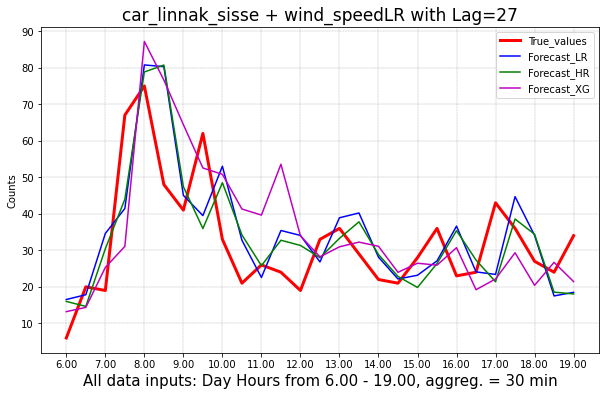

This is shape of train (4077, 55) 

This is shape of test (27, 55) 

Length of y_true 27
Length of y_hat 27
car_linnak_valja + wind_speedLR. This is MAE of Lin.Regression 11.952677754630217
car_linnak_valja + wind_speedLR. This is MAE of HuberRegressor 11.841734538318365
car_linnak_valja + wind_speedLR. This is MAE of XGBoost 12.260755477128205


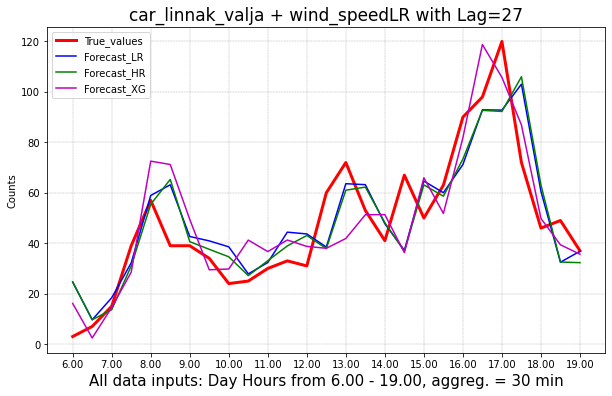

This is shape of train (4077, 55) 

This is shape of test (27, 55) 

Length of y_true 27
Length of y_hat 27
van_linnak_sisse + wind_speedLR. This is MAE of Lin.Regression 2.963552679701837
van_linnak_sisse + wind_speedLR. This is MAE of HuberRegressor 2.940864431181145
van_linnak_sisse + wind_speedLR. This is MAE of XGBoost 3.2653648632544057


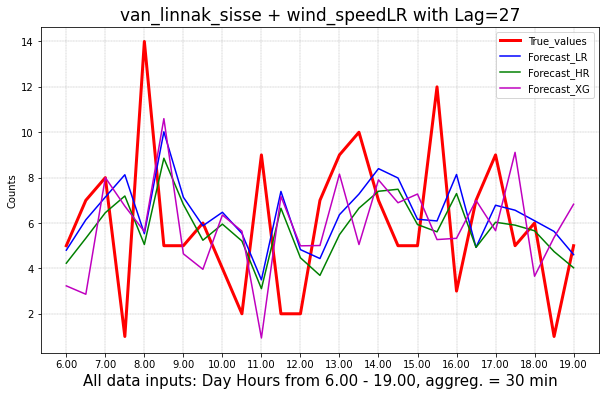

This is shape of train (4077, 55) 

This is shape of test (27, 55) 

Length of y_true 27
Length of y_hat 27
van_linnak_valja + wind_speedLR. This is MAE of Lin.Regression 2.889536416513999
van_linnak_valja + wind_speedLR. This is MAE of HuberRegressor 2.7208756999964234
van_linnak_valja + wind_speedLR. This is MAE of XGBoost 3.1551647539492005


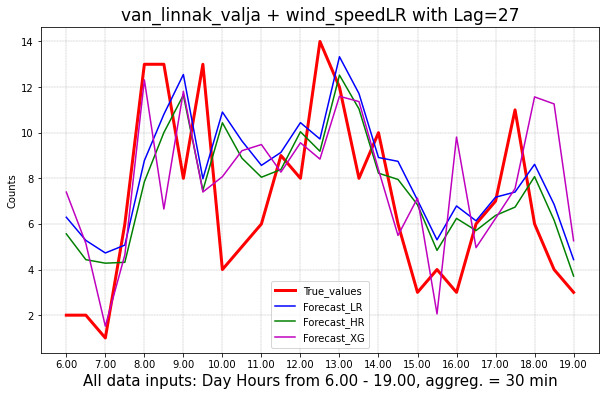

In [153]:
traffic_weatherOne(traffic_dict, carvan_windLR27, 'wind_speedLR', lag=27)

## ORIGINAL TRAFFIC DATA + TEMPERATURE_ORIG

This is shape of train (4077, 55) 

This is shape of test (27, 55) 

Length of y_true 27
Length of y_hat 27
car_linnak_sisse + temp_orig. This is MAE of Lin.Regression 11.02564838590512
car_linnak_sisse + temp_orig. This is MAE of HuberRegressor 10.608014813391165
car_linnak_sisse + temp_orig. This is MAE of XGBoost 10.413258958745885


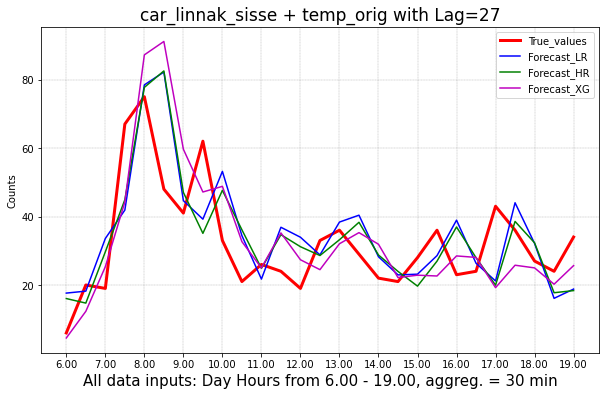

This is shape of train (4077, 55) 

This is shape of test (27, 55) 

Length of y_true 27
Length of y_hat 27
car_linnak_valja + temp_orig. This is MAE of Lin.Regression 11.308647684547688
car_linnak_valja + temp_orig. This is MAE of HuberRegressor 11.477217490093992
car_linnak_valja + temp_orig. This is MAE of XGBoost 11.419158970868146


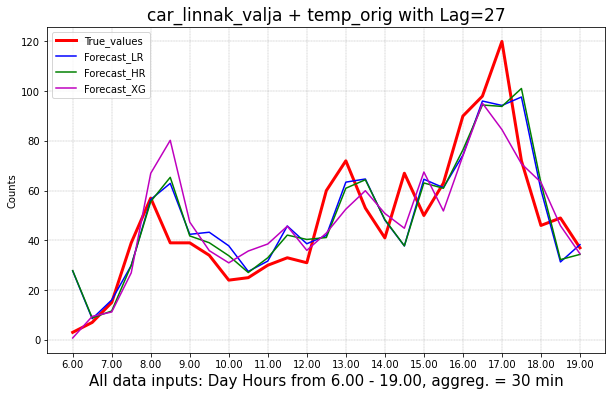

This is shape of train (4077, 55) 

This is shape of test (27, 55) 

Length of y_true 27
Length of y_hat 27
van_linnak_sisse + temp_orig. This is MAE of Lin.Regression 2.9369420495866057
van_linnak_sisse + temp_orig. This is MAE of HuberRegressor 2.9105837689997713
van_linnak_sisse + temp_orig. This is MAE of XGBoost 3.4115814809445983


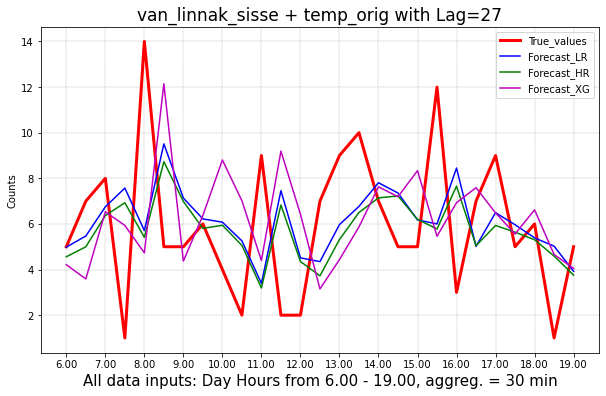

This is shape of train (4077, 55) 

This is shape of test (27, 55) 

Length of y_true 27
Length of y_hat 27
van_linnak_valja + temp_orig. This is MAE of Lin.Regression 2.842864469039959
van_linnak_valja + temp_orig. This is MAE of HuberRegressor 2.7437897222904803
van_linnak_valja + temp_orig. This is MAE of XGBoost 3.2023310396406384


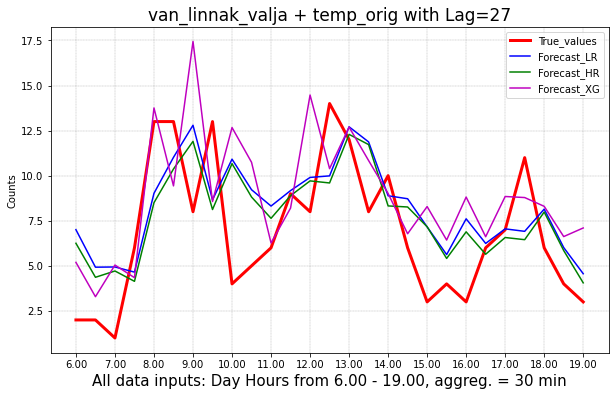

In [154]:
traffic_weatherOne(traffic_dict, carvan_tempor27, 'temp_orig', lag=27)

## ORIGINAL TRAFFIC DATA + BINARY ENCODED WEATHER_PHENOM

This is shape of train (4077, 31) 

This is shape of test (27, 31) 

Length of y_true 27
Length of y_hat 27
car_linnak_sisse + weather_phenomenaBI. This is MAE of Lin.Regression 10.603938350382304
car_linnak_sisse + weather_phenomenaBI. This is MAE of HuberRegressor 10.295217891040155
car_linnak_sisse + weather_phenomenaBI. This is MAE of XGBoost 9.58923359270449


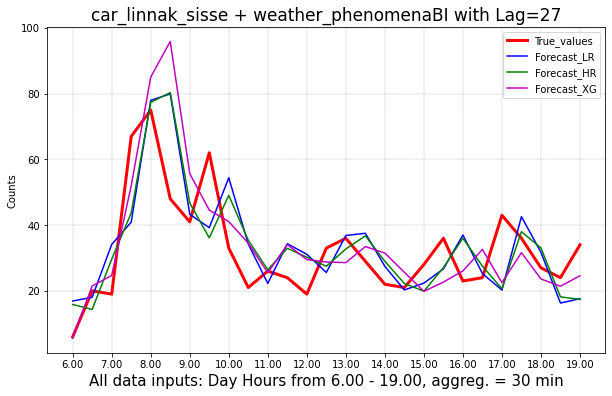

This is shape of train (4077, 31) 

This is shape of test (27, 31) 

Length of y_true 27
Length of y_hat 27
car_linnak_valja + weather_phenomenaBI. This is MAE of Lin.Regression 11.87145359821758
car_linnak_valja + weather_phenomenaBI. This is MAE of HuberRegressor 12.050256750659358
car_linnak_valja + weather_phenomenaBI. This is MAE of XGBoost 10.80913375483619


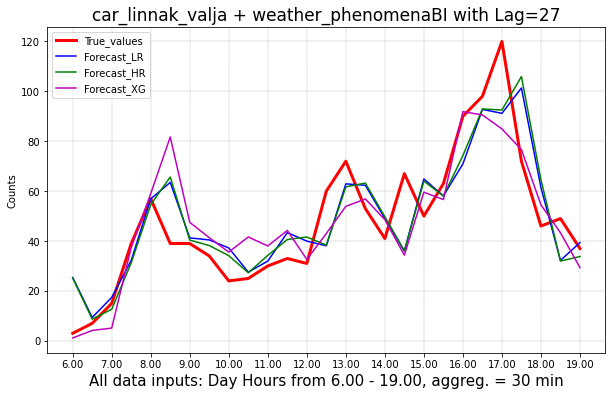

This is shape of train (4077, 31) 

This is shape of test (27, 31) 

Length of y_true 27
Length of y_hat 27
van_linnak_sisse + weather_phenomenaBI. This is MAE of Lin.Regression 2.973005546326804
van_linnak_sisse + weather_phenomenaBI. This is MAE of HuberRegressor 2.952252480742616
van_linnak_sisse + weather_phenomenaBI. This is MAE of XGBoost 2.917602044564706


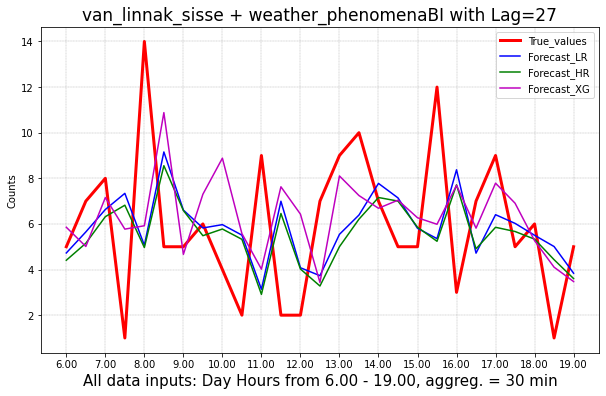

This is shape of train (4077, 31) 

This is shape of test (27, 31) 

Length of y_true 27
Length of y_hat 27
van_linnak_valja + weather_phenomenaBI. This is MAE of Lin.Regression 2.8069476966704605
van_linnak_valja + weather_phenomenaBI. This is MAE of HuberRegressor 2.7512287988428277
van_linnak_valja + weather_phenomenaBI. This is MAE of XGBoost 3.1475263878151223


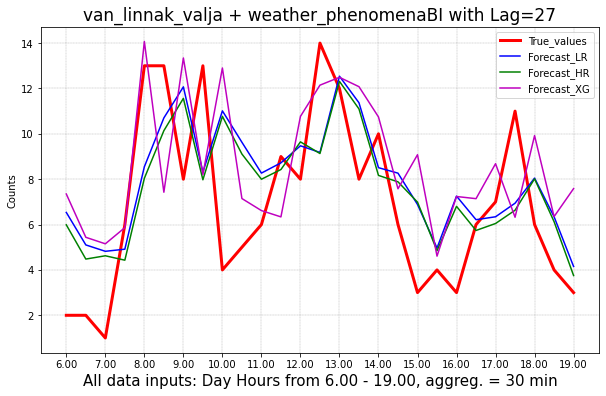

In [155]:
traffic_weatherOne(traffic_dict, wphen_bin_lag27, 'weather_phenomenaBI', lag=27)

## ORIGINAL TRAFFIC DATA + BINARY ENCODED WEATHER_PHENOM + AIR TEMPERTURE

In [154]:
 weatph_temp = np.concatenate( (wphen_bin_lag27, carvan_tempor27), axis=1)

This is shape of train (4077, 58) 

This is shape of test (27, 58) 

Length of y_true 27
Length of y_hat 27
car_linnak_sisse + weather_phenBI + temperature. This is MAE of Lin.Regression 11.023258312173803
car_linnak_sisse + weather_phenBI + temperature. This is MAE of HuberRegressor 10.651388158891002
car_linnak_sisse + weather_phenBI + temperature. This is MAE of XGBoost 9.671932026191994


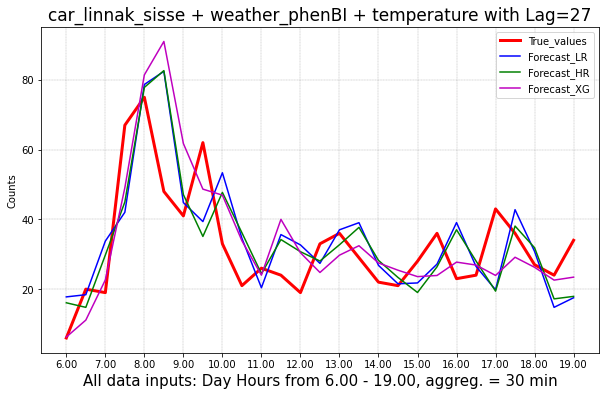

This is shape of train (4077, 58) 

This is shape of test (27, 58) 

Length of y_true 27
Length of y_hat 27
car_linnak_valja + weather_phenBI + temperature. This is MAE of Lin.Regression 11.269329662575752
car_linnak_valja + weather_phenBI + temperature. This is MAE of HuberRegressor 11.49090732080728
car_linnak_valja + weather_phenBI + temperature. This is MAE of XGBoost 11.081002928592541


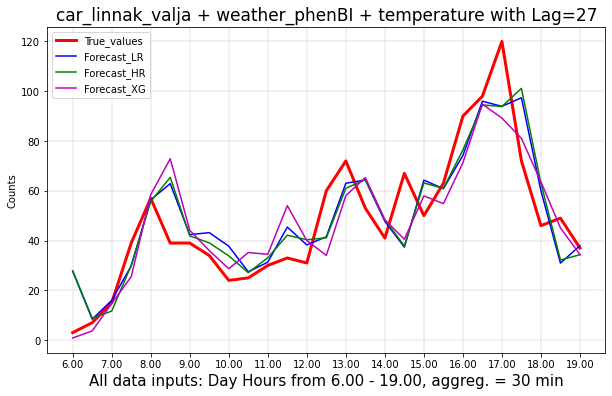

This is shape of train (4077, 58) 

This is shape of test (27, 58) 

Length of y_true 27
Length of y_hat 27
van_linnak_sisse + weather_phenBI + temperature. This is MAE of Lin.Regression 2.949464242937547
van_linnak_sisse + weather_phenBI + temperature. This is MAE of HuberRegressor 2.9298627988233528
van_linnak_sisse + weather_phenBI + temperature. This is MAE of XGBoost 2.967746310763889


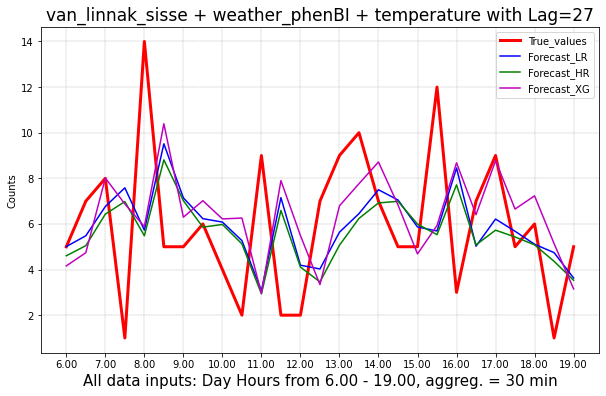

This is shape of train (4077, 58) 

This is shape of test (27, 58) 

Length of y_true 27
Length of y_hat 27
van_linnak_valja + weather_phenBI + temperature. This is MAE of Lin.Regression 2.772646172984593
van_linnak_valja + weather_phenBI + temperature. This is MAE of HuberRegressor 2.710221662244197
van_linnak_valja + weather_phenBI + temperature. This is MAE of XGBoost 3.1085450031139232


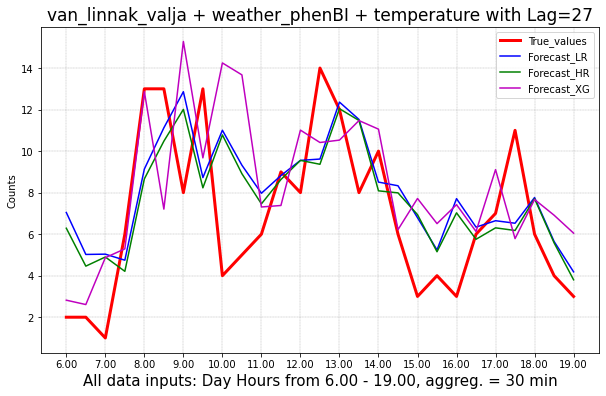

In [157]:
traffic_weatherOne(traffic_dict,  weatph_temp, 'weather_phenBI + temperature', lag=27)

## FEATURE  IMPORTANCE in XGBoost model

* Built-in feature_importances plot;
* SHAP

In [155]:
path

'/home/meik/Mainor_ylemiste/report/figures/pdf_figures/'

In [156]:
def cmap_to_colors(cmap: str,
                   amount: int) -> List[str]:
    cmap = mcm.get_cmap(cmap)
    colors = [color_to_hex(cmap(i))
              for i in np.linspace(0, 1, amount)]
    return colors

In [157]:
def color_to_hex(color: Tuple[float]) -> str:
    color = [i * 255 if i * 255 <= 255 else i * 255 - 1
             for i in color[:-1]]
    color = [int(round(i)) for i in color]
    return "#%02x%02x%02x" % tuple(color)

In [178]:
#XGBoost Regressor + feature importance
def xg_boost_fimportance(train, testX, field_name):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000,importance_type='gain')# 'reg:squarederror' Loss f-on
    model.fit(trainX, trainy)
    
    #aggreg = asarray( ['0:6.00', '1:6.30', '2:7.00', '3:7.30', '4:8.00', '5:8.30', '6:9.00', '7:9.30',
    #                 '8:10.00', '9:10.30', '10:11.00', '11:11.30', '12:12.00', '13:12.30', '14:13.00', 
    #                 '15:13.30', '16:14.00', '17:14.30', '18:15.00', '19:15.30', '20:16.00', '21:16.30',
    #                                  '22:17.00','23:17.30','24:18.00','25:18.30','26:19.00'])
    
    #aggreg = asarray (['0:6.00', '1:6.30', '2:7.00', '3:7.30', '4:8.00', '5:8.30', '6:9.00', '7:9.30', '8:10.00', '9:10.30',
    #  '10:11.00', '11:11.30', '12:12.00', '13:12.30', '14:13.00', '15:13.30', '16:14.00', '17:14.30','18:15.00',
    #  '19:15.30', '20:16.00', '21:16.30', '22:17.00','23:17.30','24:18.00','25:18.30','26:19.00',
    #  
    # '27:6.00', '28:6.30', '29:7.00', '30:7.30', '31:8.00', '32:8.30','33:9.00', '34:9.30','35:10.00','36:10.30',
    #  '37:11.00', '38:11.30', '39:12.00', '40:12.30', '41:13.00', '42:13.30', '43:14.00', '44:14.30','45:15.00',
    # '46:15.30', '47:16.00', '48:16.30', '49:17.00','50:17.30','51:18.00','52:18.30','53:19.00'
    #]) 
    
    aggreg = asarray (['0:CAT0', '1:CAT1', '2:CAT2',     
     '3:6.00', '4:6.30', '5:7.00', '6:7.30', '7:8.00', '8:8.30','9:9.00', '10:9.30','11:10.00','12:10.30',
     '13:11.00', '14:11.30', '15:12.00', '16:12.30', '17:13.00', '18:13.30', '19:14.00', '20:14.30','21:15.00',
     '22:15.30', '23:16.00', '24:16.30', '25:17.00','26:17.30','27:18.00','28:18.30','29:19.00'
    ])
       
    # F-score feature importance
    #model.get_booster().get_score()#importance_type: defaults to weight.Not normalised
    #print("Type of importance used", model.importance_type)
    #plot_importance(model)
    #pyplot.show()
    
    #BUILT-IN feature importance. Importance is        
    sorted_idx = model.feature_importances_.argsort()# default is "gain"
    plt.rcParams["figure.figsize"] = (12,7);
    plt.barh(aggreg[sorted_idx], model.feature_importances_[sorted_idx])
    plt.xlabel(f"{field_name} Xgboost Built-In Feature Importance. Importance type:'gain'.", size=15) 
    
    plt.savefig(f"feat_impGain{field_name}.pdf", format="pdf", bbox_inches="tight")

In [179]:
def walk_forward_validationXGB_fimportance(data, n_test, field_name):
    
    predictionsXG = list()    
    # split dataset
    train, test = train_test_split(data, n_test)

    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        
        # fit model on history and make a prediction
        yhatXG = xg_boost_fimportance(history, testX, field_name)
        
        # store forecast in list of predictions
        predictionsXG.append(yhatXG)
        
        # add actual observation to history for the next loop
        history.append(test[i])


## BY BUILT-IN FEATURE_IMPORTANCES (INFORMATION TYPE: 'GAIN')

### Traffic + wind speed

In [160]:
carin_wind = np.concatenate( (carvan_windLR27, car_sslinBM27), axis=1)

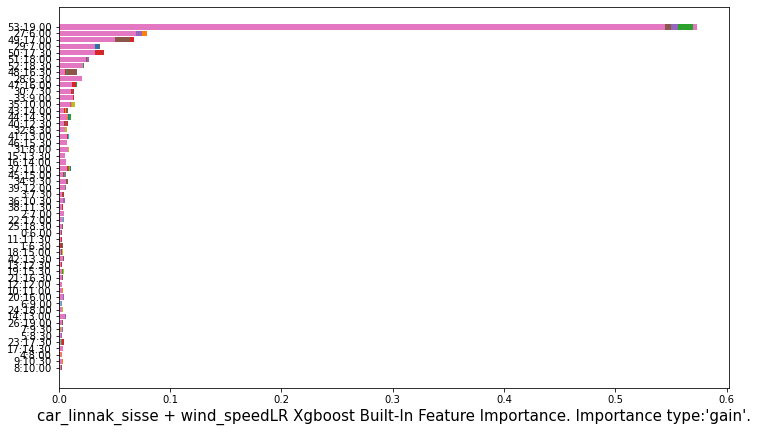

In [263]:
walk_forward_validationXGB_fimportance(carin_wind, 27, 'car_linnak_sisse + wind_speedLR')

In [161]:
carout_wind = np.concatenate( (carvan_windLR27, car_ssloutBM27), axis=1)

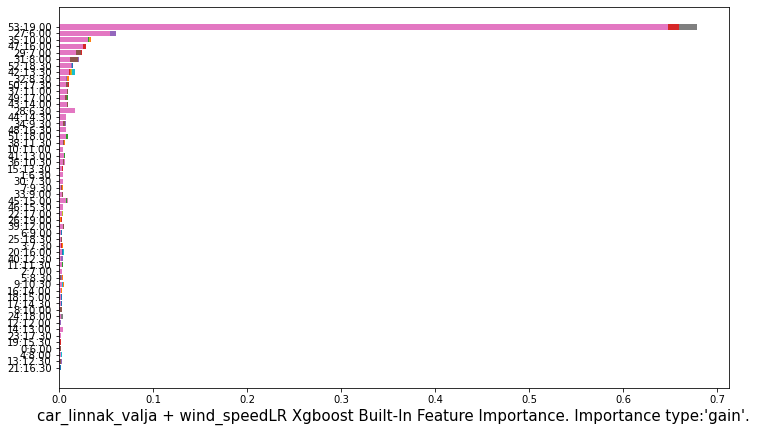

In [265]:
walk_forward_validationXGB_fimportance(carout_wind, 27, 'car_linnak_valja + wind_speedLR')

In [162]:
vanin_wind = np.concatenate( (carvan_windLR27, van_sslinBM27), axis=1)

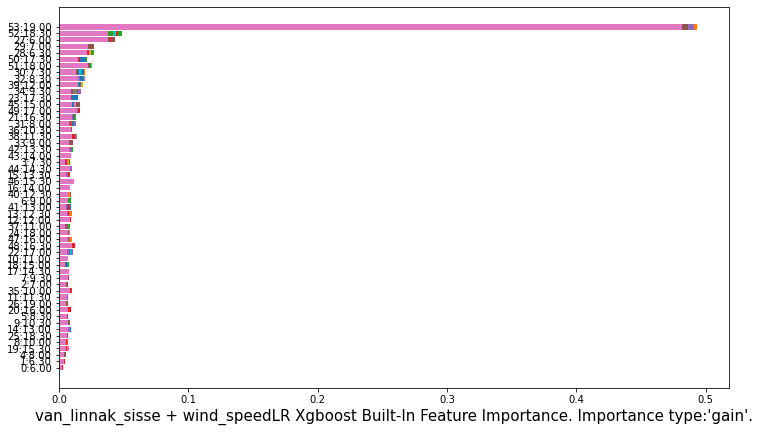

In [267]:
walk_forward_validationXGB_fimportance(vanin_wind, 27, 'van_linnak_sisse + wind_speedLR')

In [163]:
vanout_wind = np.concatenate( (carvan_windLR27, van_ssloutBM27), axis=1)

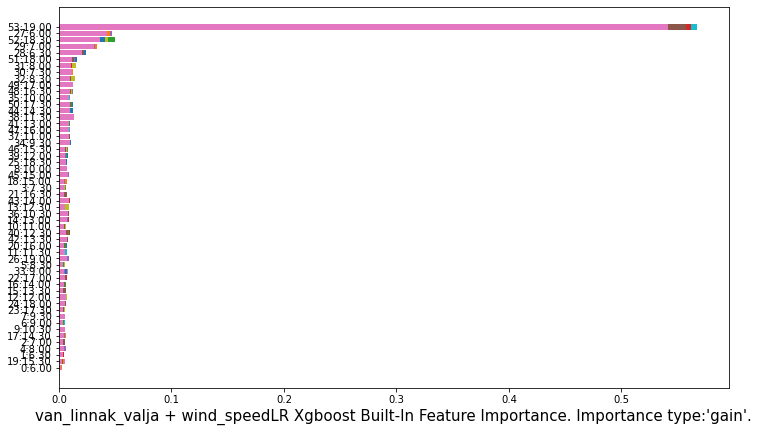

In [269]:
walk_forward_validationXGB_fimportance(vanout_wind, 27, 'van_linnak_valja + wind_speedLR')

### Traffic + Temperature 

In [164]:
carin_temp = np.concatenate( (carvan_tempor27, car_sslinBM27), axis=1)

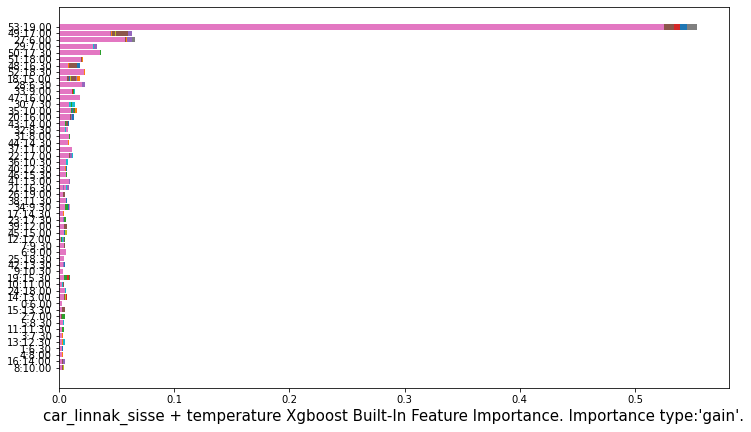

In [271]:
walk_forward_validationXGB_fimportance(carin_temp, 27, 'car_linnak_sisse + temperature')

In [165]:
carout_temp = np.concatenate( (carvan_tempor27, car_ssloutBM27), axis=1)

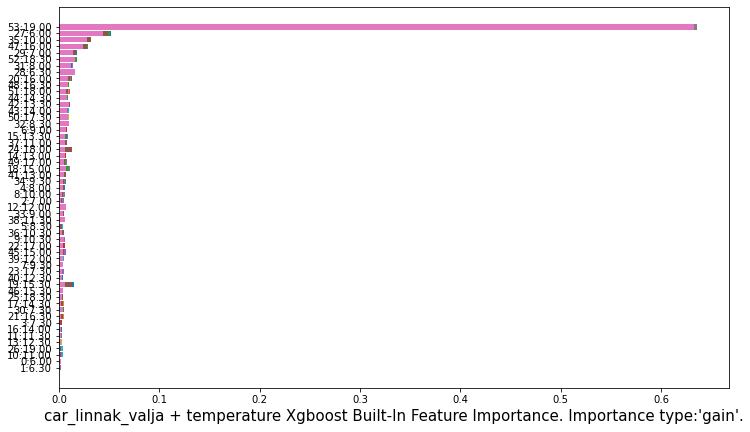

In [273]:
walk_forward_validationXGB_fimportance(carout_temp, 27, 'car_linnak_valja + temperature')

In [166]:
vanin_temp = np.concatenate( (carvan_tempor27, van_sslinBM27), axis=1)

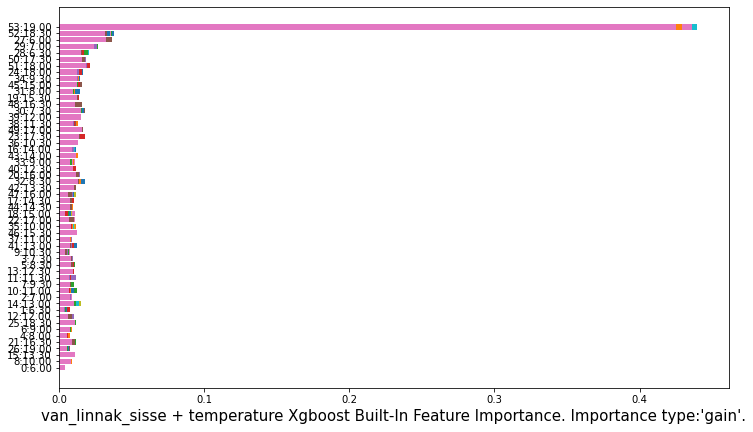

In [275]:
walk_forward_validationXGB_fimportance(vanin_temp, 27, 'van_linnak_sisse + temperature')

In [167]:
vanout_temp = np.concatenate( (carvan_tempor27, van_ssloutBM27), axis=1)

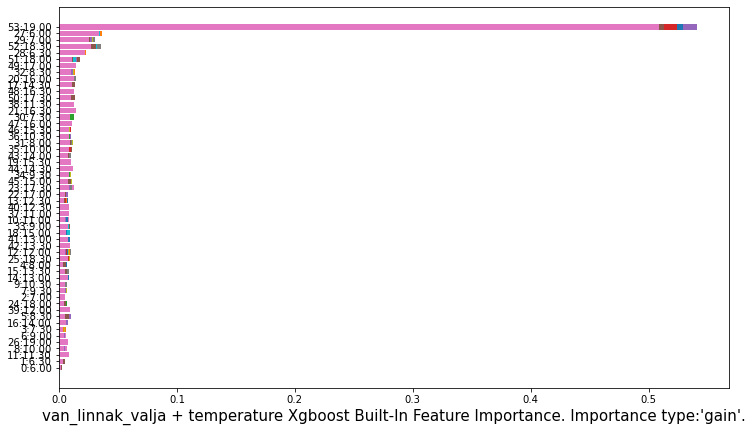

In [277]:
walk_forward_validationXGB_fimportance(vanout_temp, 27, 'van_linnak_valja + temperature')

### Traffic + Weather phenomena

In [168]:
carin_weaph = np.concatenate( (wphen_bin_lag27, car_sslinBM27), axis=1)

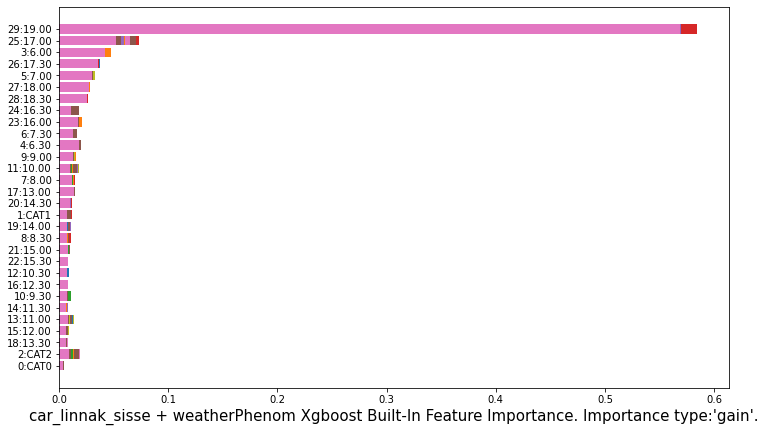

In [180]:
walk_forward_validationXGB_fimportance(carin_weaph, 27, 'car_linnak_sisse + weatherPhenom')

In [169]:
carout_weaph = np.concatenate( (wphen_bin_lag27, car_ssloutBM27), axis=1)

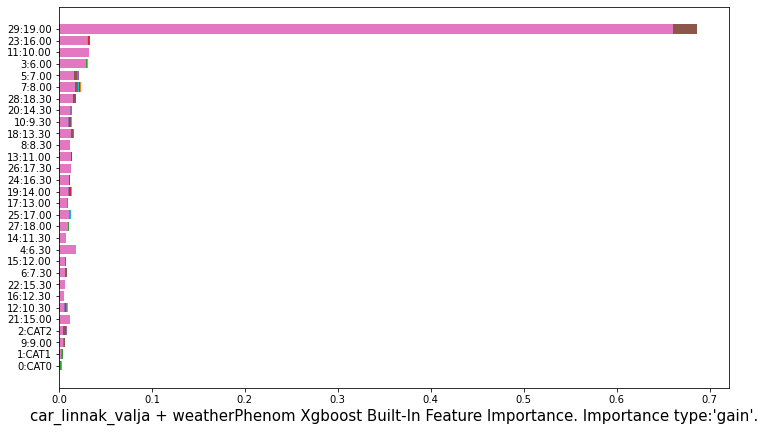

In [181]:
walk_forward_validationXGB_fimportance(carout_weaph, 27, 'car_linnak_valja + weatherPhenom')

In [170]:
vanin_weaph = np.concatenate( (wphen_bin_lag27, van_sslinBM27), axis=1)

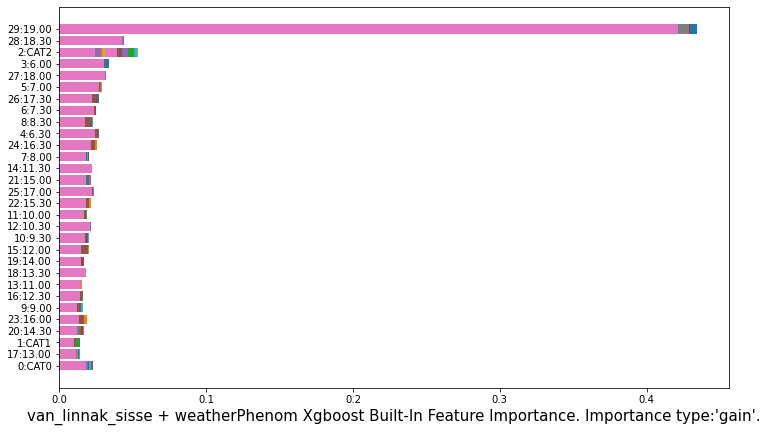

In [182]:
walk_forward_validationXGB_fimportance(vanin_weaph, 27, 'van_linnak_sisse + weatherPhenom')

In [171]:
vanout_weaph = np.concatenate( (wphen_bin_lag27, van_ssloutBM27), axis=1)

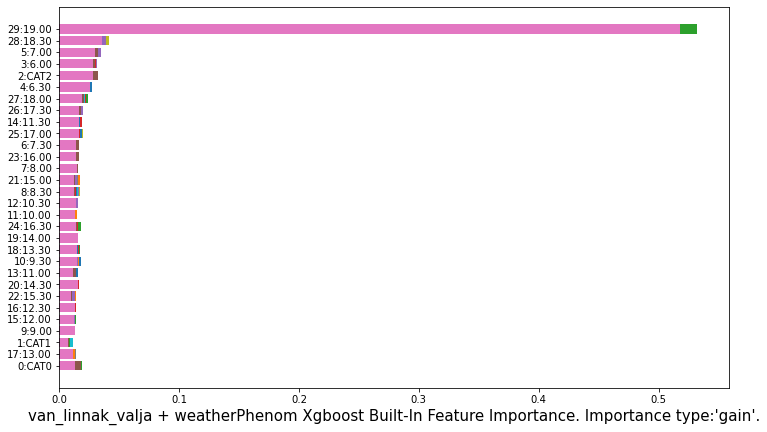

In [183]:
walk_forward_validationXGB_fimportance(vanout_weaph, 27, 'van_linnak_valja + weatherPhenom')

## BY SHAP

In [172]:
def xg_boost_fimpSHAP(train, testX, field_name):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000,importance_type='gain')# 'reg:squarederror' Loss f-on
    model.fit(trainX, trainy)
       
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(asarray([testX]))

    return shap_values


In [173]:
def walk_forward_validationXGB_SHAP(data, n_test, field_name):
    
    train, test = train_test_split(data, n_test)

    # seed history with training dataset
    history = [x for x in train]
    
    #aggreg = asarray( ['0:6.00', '1:6.30', '2:7.00', '3:7.30', '4:8.00', '5:8.30', '6:9.00', '7:9.30',
     #                '8:10.00', '9:10.30', '10:11.00', '11:11.30', '12:12.00', '13:12.30', '14:13.00', 
     #                '15:13.30', '16:14.00', '17:14.30', '18:15.00', '19:15.30', '20:16.00', '21:16.30',
     #                                 '22:17.00','23:17.30','24:18.00','25:18.30','26:19.00'])
    
    #aggreg = asarray (['0:6.00', '1:6.30', '2:7.00', '3:7.30', '4:8.00', '5:8.30', '6:9.00', '7:9.30', '8:10.00', '9:10.30',
    #  '10:11.00', '11:11.30', '12:12.00', '13:12.30', '14:13.00', '15:13.30', '16:14.00', '17:14.30','18:15.00',
    #  '19:15.30', '20:16.00', '21:16.30', '22:17.00','23:17.30','24:18.00','25:18.30','26:19.00',
    #  
    # '27:6.00', '28:6.30', '29:7.00', '30:7.30', '31:8.00', '32:8.30','33:9.00', '34:9.30','35:10.00','36:10.30',
    #  '37:11.00', '38:11.30', '39:12.00', '40:12.30', '41:13.00', '42:13.30', '43:14.00', '44:14.30','45:15.00',
    #  '46:15.30', '47:16.00', '48:16.30', '49:17.00','50:17.30','51:18.00','52:18.30','53:19.00'
    #]) 
    
    aggreg = asarray (['0:CAT0', '1:CAT1', '2:CAT2',     
     '3:6.00', '4:6.30', '5:7.00', '6:7.30', '7:8.00', '8:8.30','9:9.00', '10:9.30','11:10.00','12:10.30',
      '13:11.00', '14:11.30', '15:12.00', '16:12.30', '17:13.00', '18:13.30', '19:14.00', '20:14.30','21:15.00',
     '22:15.30', '23:16.00', '24:16.30', '25:17.00','26:17.30','27:18.00','28:18.30','29:19.00'
    ])
  
    shap_values_last = xg_boost_fimpSHAP(history,  test[0, :-1], field_name)
    shap.summary_plot(shap_values_last, asarray([test[0, :-1]]), show=False,feature_names = aggreg,
                      color_bar_label = 'Feature value')
    # step over each time-step in the test set
    for i in range(1, len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        
        shap_values = xg_boost_fimpSHAP(history, testX, field_name)
        shap.summary_plot(shap_values, asarray([testX]), show=False,feature_names = aggreg,color_bar_label = '')
        plt.savefig(f"SHAP{field_name}.pdf", format="pdf", bbox_inches="tight")
        plt.tight_layout()
      

## CARS_IN

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

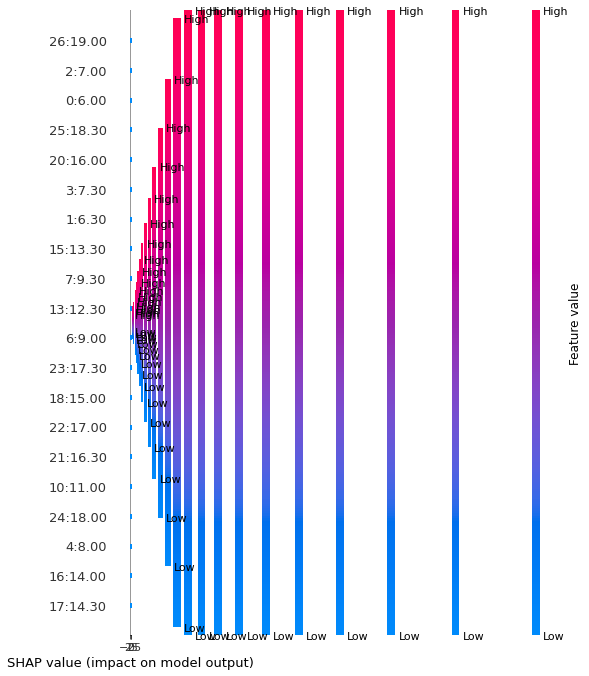

In [211]:
walk_forward_validationXGB_SHAP(car_sslinBM27, 27, 'car_linnak_sisse')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

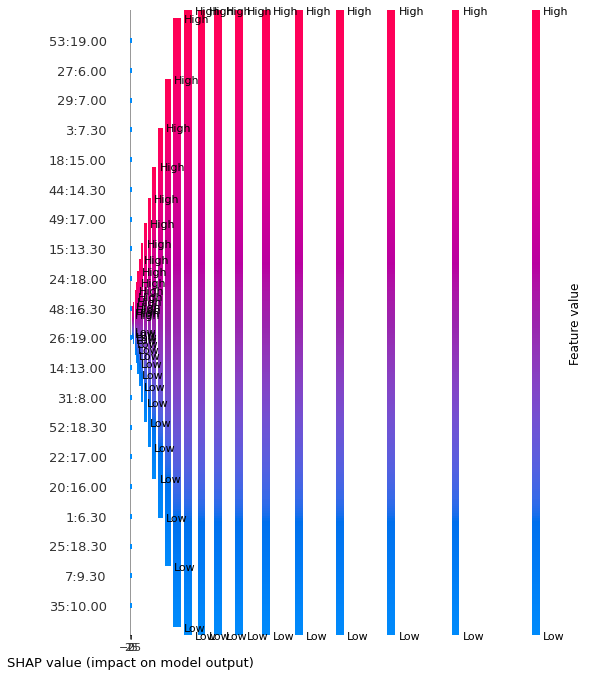

In [231]:
walk_forward_validationXGB_SHAP(carin_wind, 27, 'car_linnak_sisse + wind_speed')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

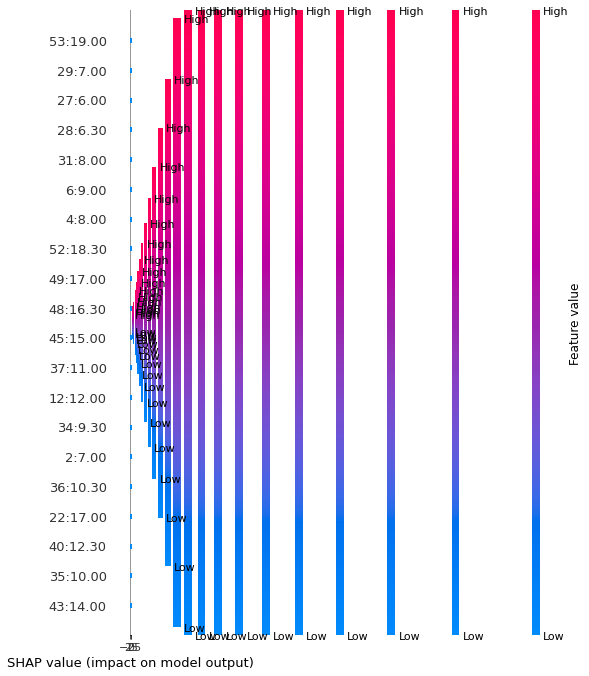

In [232]:
walk_forward_validationXGB_SHAP(carin_temp, 27, 'car_linnak_sisse + temperature')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

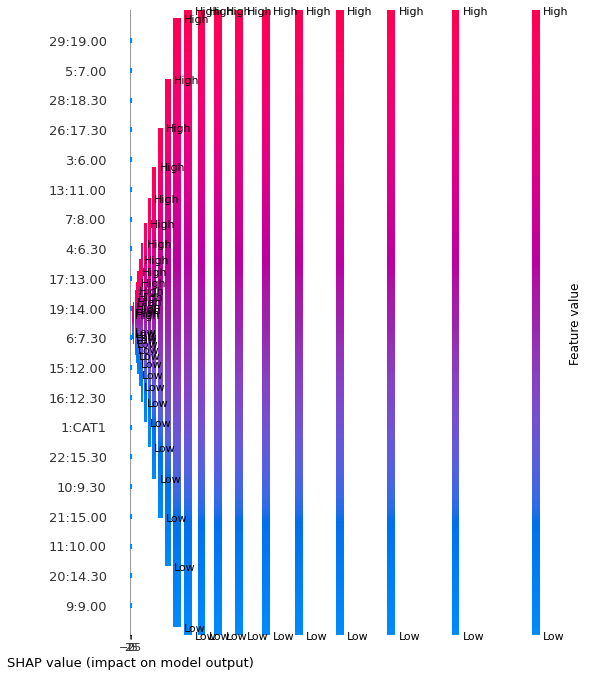

In [174]:
walk_forward_validationXGB_SHAP(carin_weaph, 27, 'car_linnak_sisse + weatherPhenom')

## CARS_OUT

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

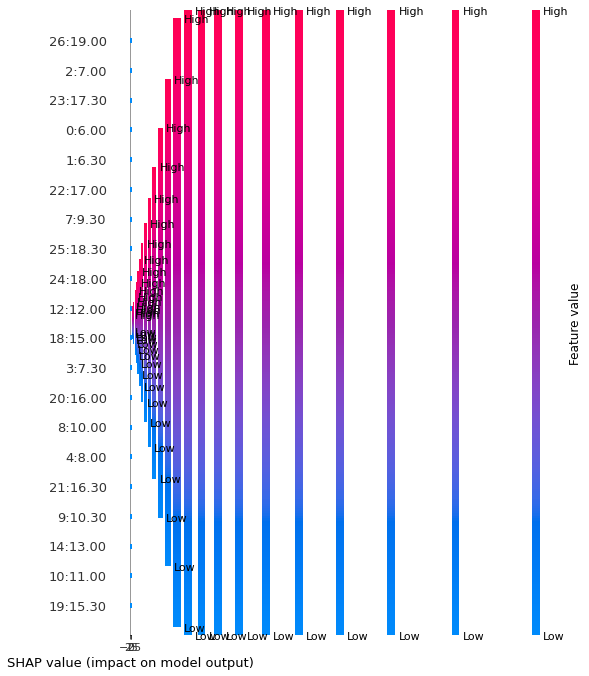

In [216]:
walk_forward_validationXGB_SHAP(car_ssloutBM27, 27, 'car_linnak_valja')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

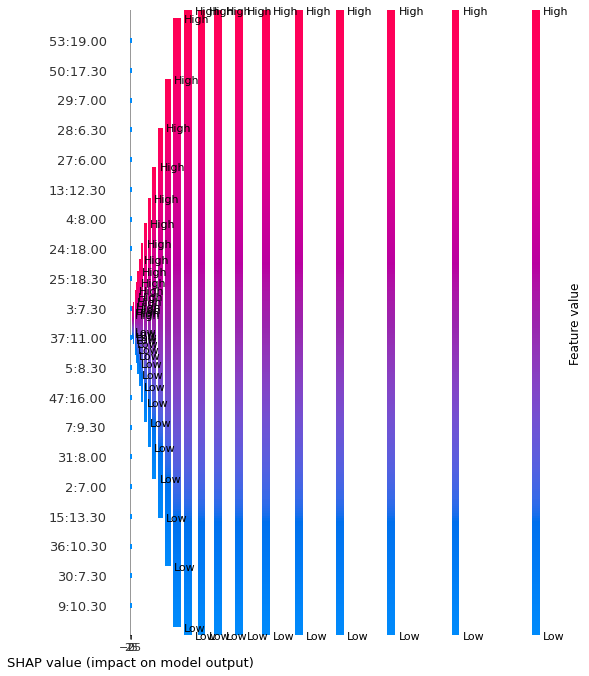

In [233]:
walk_forward_validationXGB_SHAP(carout_wind, 27, 'car_linnak_valja + wind_speed')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

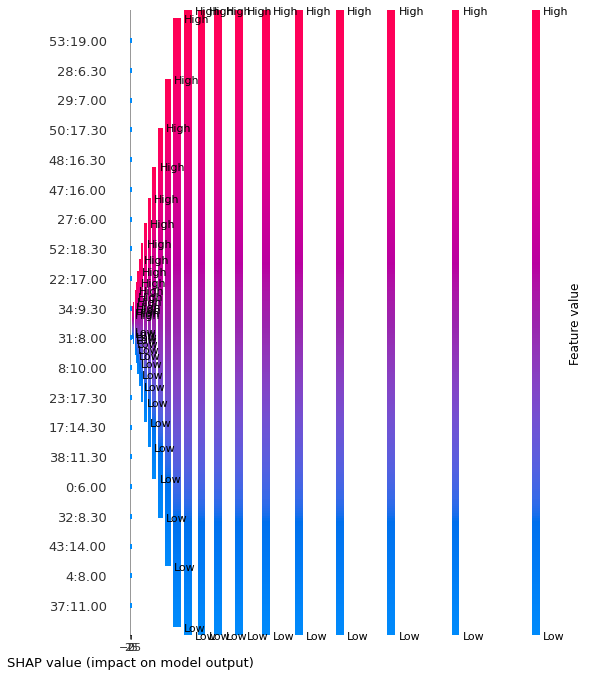

In [234]:
walk_forward_validationXGB_SHAP(carout_temp, 27, 'car_linnak_valja + temperature')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

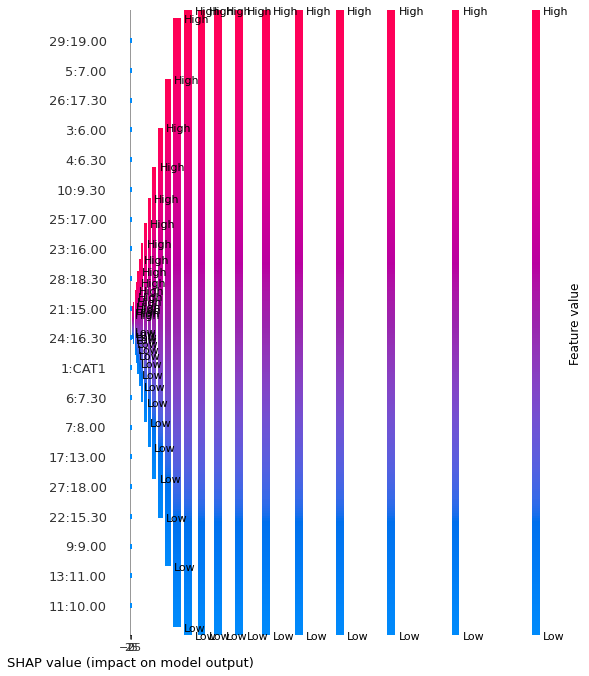

In [175]:
walk_forward_validationXGB_SHAP(carout_weaph, 27, 'car_linnak_valja + weatherPhenom')

## VANS_IN

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

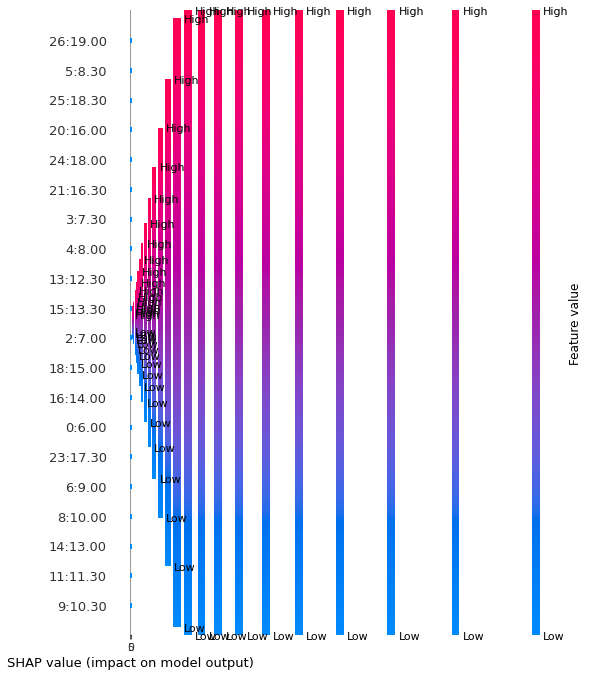

In [249]:
walk_forward_validationXGB_SHAP(van_sslinBM27, 27, 'van_linnak_sisse')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

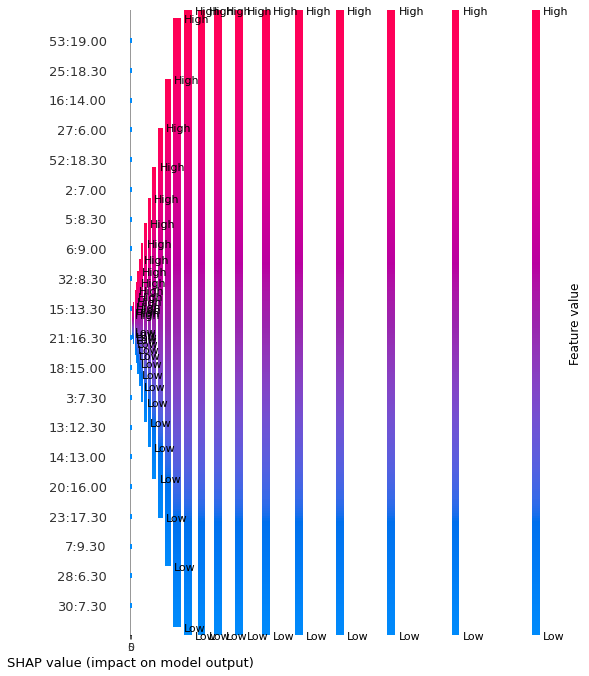

In [244]:
walk_forward_validationXGB_SHAP(vanin_wind, 27, 'van_linnak_sisse + wind_speed')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

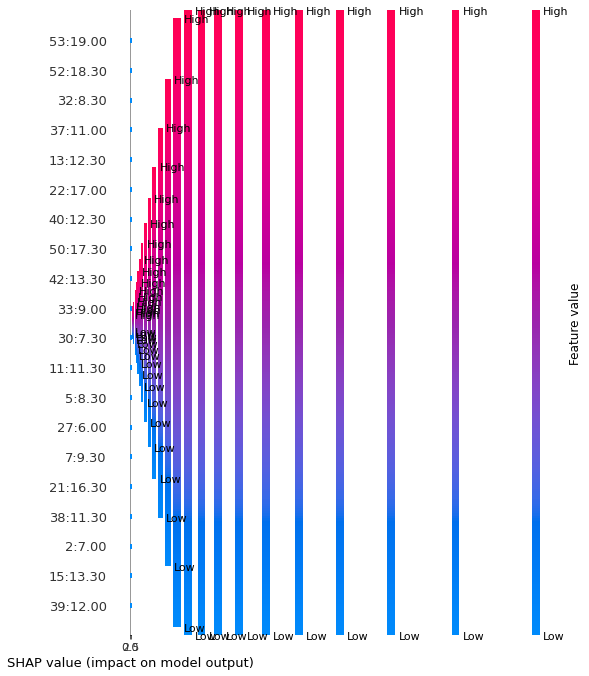

In [245]:
walk_forward_validationXGB_SHAP(vanin_temp, 27, 'van_linnak_sisse + temperature')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

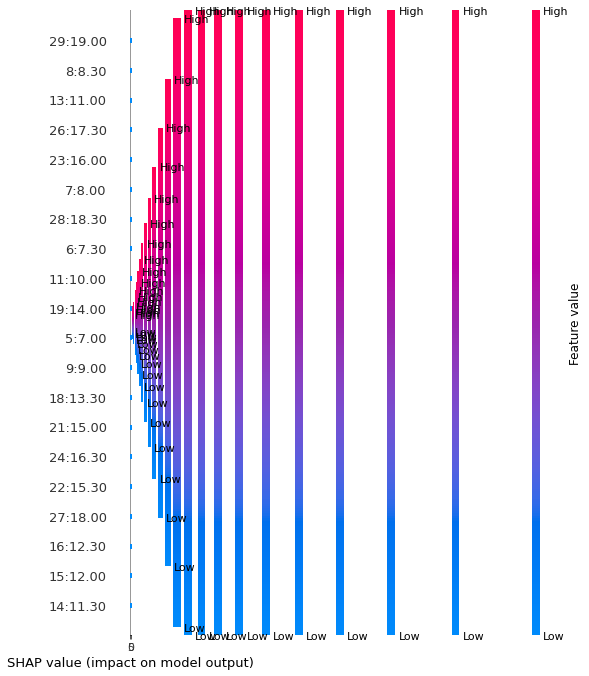

In [176]:
walk_forward_validationXGB_SHAP(vanin_weaph, 27, 'van_linnak_sisse + weatherPhenom')

## VANS_OUT

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

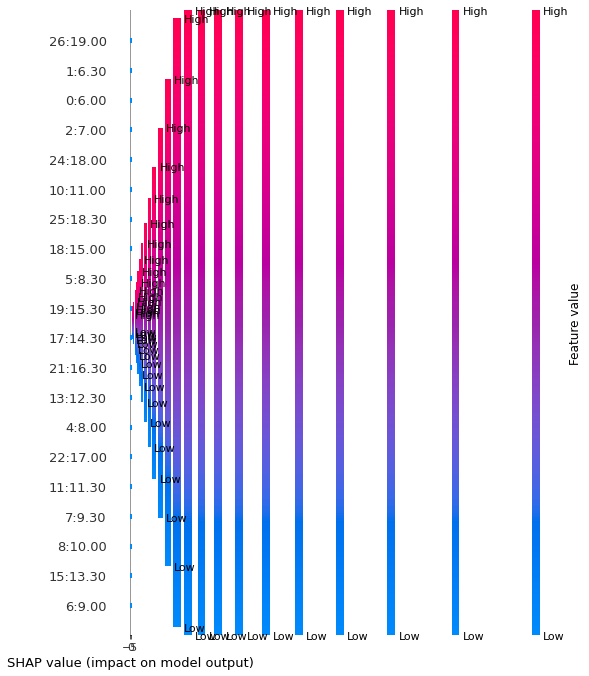

In [250]:
walk_forward_validationXGB_SHAP(van_ssloutBM27, 27, 'van_linnak_valja')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

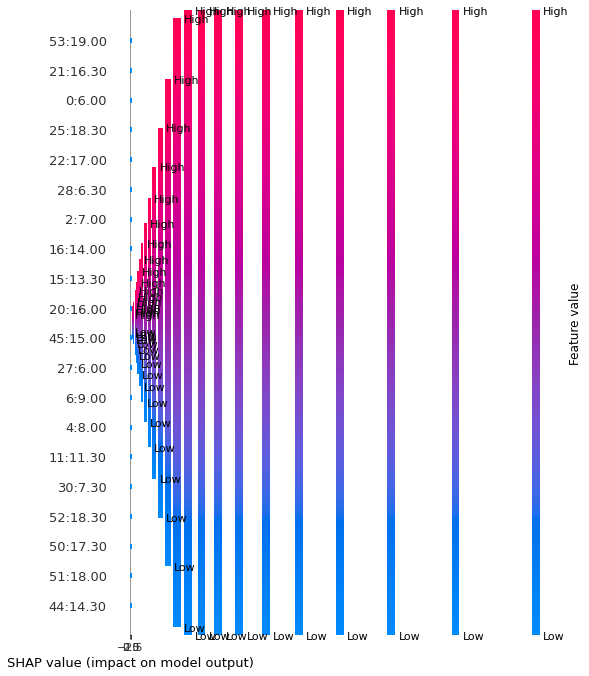

In [246]:
walk_forward_validationXGB_SHAP(vanout_wind, 27, 'van_linnak_valja + wind_speed')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

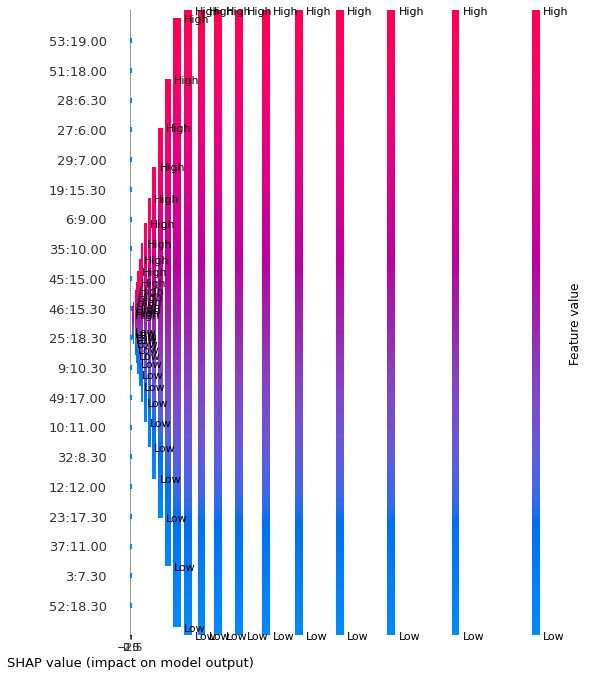

In [247]:
walk_forward_validationXGB_SHAP(vanout_temp, 27, 'van_linnak_valja + temperature')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

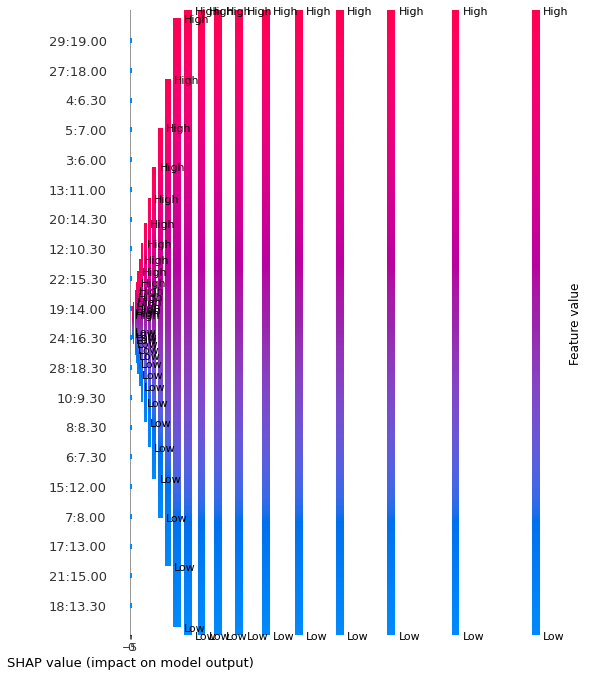

In [177]:
walk_forward_validationXGB_SHAP(vanout_weaph, 27, 'van_linnak_valja + weatherPhenom')